In [1]:
'''
Zhou, F. (2014). Geographical Origin of Music [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5VK5D.
'''

'\nZhou, F. (2014). Geographical Origin of Music [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5VK5D.\n'

## Requirements

In [2]:
pip install geopy

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.1-py3-none-any.whl.metadata (1.6 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.1-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.


In [150]:
#Libraries
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from geopy.geocoders import Nominatim
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import time
import networkx as nx
from sklearn.metrics import accuracy_score,balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, silhouette_samples
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import pairwise_distances
from itertools import combinations
#Libraries for testing
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform

## Load dataset

In [4]:
#Load dataset, comparing if more information (using chromatic features) imporves the classification
df_68 = pd.read_csv('/home/laurey/DSP/Project/default_features_1059_tracks.csv', header=None) #Without chromatic features
df_116 = pd.read_csv('/home/laurey/DSP/Project/default_plus_chromatic_features_1059_tracks.csv', header=None)

## Exploring dataset

In [5]:
#Explore the dataset
print(f'Dataset without chromatic features\nObservations: {df_68.shape[0]}\nFeatures: {df_68.shape[1]}\nFeatures with NA: {df_68.isna().sum()[df_68.isna().sum() > 0].index.tolist()}')
print(f'Dataset with chromatic features\nObservations: {df_116.shape[0]}\nFeatures: {df_116.shape[1]}\nFeatures with NA: {df_116.isna().sum()[df_116.isna().sum() > 0].index.tolist()}')

Dataset without chromatic features
Observations: 1059
Features: 70
Features with NA: []
Dataset with chromatic features
Observations: 1059
Features: 118
Features with NA: []


In [6]:
#Visualise the structure of the dataset
df_68.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-1.504263,0.351267,-1.018726,-0.174878,-1.089543,-0.668840,-0.914772,-0.836250,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,-0.495712,-0.465077,-0.157861,-0.157189,0.380951,1.088478,-0.123595,1.391141,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,-0.637167,0.147260,0.217914,2.718442,0.972919,2.081069,1.375763,1.063847,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,-0.178325,-0.065059,-0.724247,-1.020687,-0.751380,-0.385005,-0.012326,-0.392197,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,-0.919463,-0.667912,-0.820172,-0.190488,0.306974,0.119658,0.271838,1.289783,34.03,-6.85


In [7]:
#Visualise the structure of the dataset
df_116.head()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,34.03,-6.85


In [8]:
print(df_68.info())
print(df_116.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 70 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1059 non-null   float64
 1   1       1059 non-null   float64
 2   2       1059 non-null   float64
 3   3       1059 non-null   float64
 4   4       1059 non-null   float64
 5   5       1059 non-null   float64
 6   6       1059 non-null   float64
 7   7       1059 non-null   float64
 8   8       1059 non-null   float64
 9   9       1059 non-null   float64
 10  10      1059 non-null   float64
 11  11      1059 non-null   float64
 12  12      1059 non-null   float64
 13  13      1059 non-null   float64
 14  14      1059 non-null   float64
 15  15      1059 non-null   float64
 16  16      1059 non-null   float64
 17  17      1059 non-null   float64
 18  18      1059 non-null   float64
 19  19      1059 non-null   float64
 20  20      1059 non-null   float64
 21  21      1059 non-null   float64
 22  

In [9]:
df_68.describe()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,-0.019312,-0.021095,-0.029824,-0.041360,0.025364,0.003521,-0.021183,0.010021,-0.030965,-0.017495,...,0.025828,0.019925,0.025629,0.021065,0.027439,0.019795,0.023401,0.022533,26.651294,38.405656
std,0.987911,0.986098,0.972813,0.984577,0.999363,1.000305,0.989127,1.007714,1.007447,1.017138,...,1.012146,1.009817,1.008802,1.000416,1.000374,1.003078,1.011060,1.007017,18.459432,50.419790
min,-1.529463,-1.476560,-1.133667,-3.222673,-3.386389,-4.366687,-4.291933,-5.287408,-5.281537,-6.856486,...,-1.597512,-1.579654,-1.614369,-1.505952,-1.404766,-1.248702,-1.221595,-1.329595,-35.300000,-88.760000
25%,-0.607617,-0.621808,-0.599230,-0.640633,-0.599677,-0.633760,-0.608229,-0.556419,-0.513522,-0.464189,...,-0.668874,-0.680484,-0.692833,-0.660135,-0.693410,-0.652469,-0.641316,-0.658826,14.660000,3.210000
50%,-0.184135,-0.211257,-0.301310,-0.134986,0.157396,0.011760,0.037887,0.042447,0.074414,0.091507,...,-0.207786,-0.203502,-0.182283,-0.191193,-0.237980,-0.252907,-0.315654,-0.304111,33.660000,32.830000
75%,0.312155,0.310377,0.158689,0.459267,0.735871,0.662538,0.643826,0.574328,0.583657,0.569681,...,0.466648,0.485808,0.488015,0.476027,0.486942,0.326699,0.415290,0.352652,39.910000,74.600000
max,9.439499,10.719304,6.157847,5.926862,2.280230,2.897006,2.720127,3.127494,3.948652,3.492393,...,7.397255,5.336838,8.329566,5.854703,5.442332,6.437855,5.387364,5.977184,54.680000,149.120000


In [10]:
df_116.describe()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,-0.019312,-0.021095,-0.029824,-0.041360,0.025364,0.003521,-0.021183,0.010021,-0.030965,-0.017495,...,0.013183,0.013183,0.013183,0.013183,0.013183,0.013183,0.013183,0.013183,26.651294,38.405656
std,0.987911,0.986098,0.972813,0.984577,0.999363,1.000305,0.989127,1.007714,1.007447,1.017138,...,1.016814,1.016814,1.016814,1.016814,1.016814,1.016814,1.016814,1.016814,18.459432,50.419790
min,-1.529463,-1.476560,-1.133667,-3.222673,-3.386389,-4.366687,-4.291933,-5.287408,-5.281537,-6.856486,...,-0.850211,-0.850211,-0.850211,-0.850211,-0.850211,-0.850211,-0.850211,-0.850211,-35.300000,-88.760000
25%,-0.607617,-0.621808,-0.599230,-0.640633,-0.599677,-0.633760,-0.608229,-0.556419,-0.513522,-0.464189,...,-0.607203,-0.607203,-0.607203,-0.607203,-0.607203,-0.607203,-0.607203,-0.607203,14.660000,3.210000
50%,-0.184135,-0.211257,-0.301310,-0.134986,0.157396,0.011760,0.037887,0.042447,0.074414,0.091507,...,-0.327437,-0.327437,-0.327437,-0.327437,-0.327437,-0.327437,-0.327437,-0.327437,33.660000,32.830000
75%,0.312155,0.310377,0.158689,0.459267,0.735871,0.662538,0.643826,0.574328,0.583657,0.569681,...,0.232095,0.232095,0.232095,0.232095,0.232095,0.232095,0.232095,0.232095,39.910000,74.600000
max,9.439499,10.719304,6.157847,5.926862,2.280230,2.897006,2.720127,3.127494,3.948652,3.492393,...,8.222786,8.222786,8.222786,8.222786,8.222786,8.222786,8.222786,8.222786,54.680000,149.120000


Both datasets has not missing values and in the documentations is indicated that it was already standardised, however, it is also indicated that the data comes from 33 countries, which are latitude and longitude (last 2 columns) and as the region is the target of classification for this task, therefore, the respective columns will be renamed and a new column with the country will be assigned based on the previous information. 

## Transformation

In [11]:
#Get the features 
X_68 = df_68.iloc[:, 0:67] 
X_116 = df_116.iloc[:, 0:115]

In [12]:
#Get country by using coordinates (the last 2 columns of each dataframe)
geolocator = Nominatim(user_agent="geoapi")
def get_country(lat, lon):
    try:
        time.sleep(1.5) 
        location = geolocator.reverse((lat, lon), language='en')
        if location and 'country' in location.raw['address']:
            return location.raw['address']['country']
    except:
        return None

In [13]:
#Change coordinates name
df_68 = df_68.rename(columns={68: "Latitude", 69: "Longitude"})
df_116 = df_116.rename(columns={116: "Latitude", 117: "Longitude"})
#Assign country using coordinates
df_68['Country'] = df_68.apply(lambda r: get_country(r['Latitude'], r['Longitude']), axis=1)

In [14]:
#Encoding by country
le_68 = LabelEncoder()
y_68 = le_68.fit_transform(df_68['Country'])
#Copying the results to the 116 dataframe as both have the same rows
y_116 = y_68.copy()
df_116['Country'] = df_68['Country']

In [15]:
#If the sum is different from zero, re run the code above.
df_68['Country'].isnull().sum()

np.int64(0)

## Visualisation

In [16]:
#As both datasets have the same information excepting for the chromatic features, it will use the default one to plot 
#Create dataframe to visualise the countries and number of instances per country in a coropletic map
df_count = df_68['Country'].value_counts().reset_index()
df_count.columns = ['Country', 'Instances']
#To save and visualise using PowerBI because plotly express didn't work
df_count.to_csv('music_count.csv', index=False)  

In [17]:
df_count

,Country,Instances
0,India,69
1,Mali,66
2,Turkey,64
3,Italy,51
4,Pakistan,47
5,Greece,46
6,China,40
7,Brazil,36
8,Uzbekistan,36
9,Algeria,35


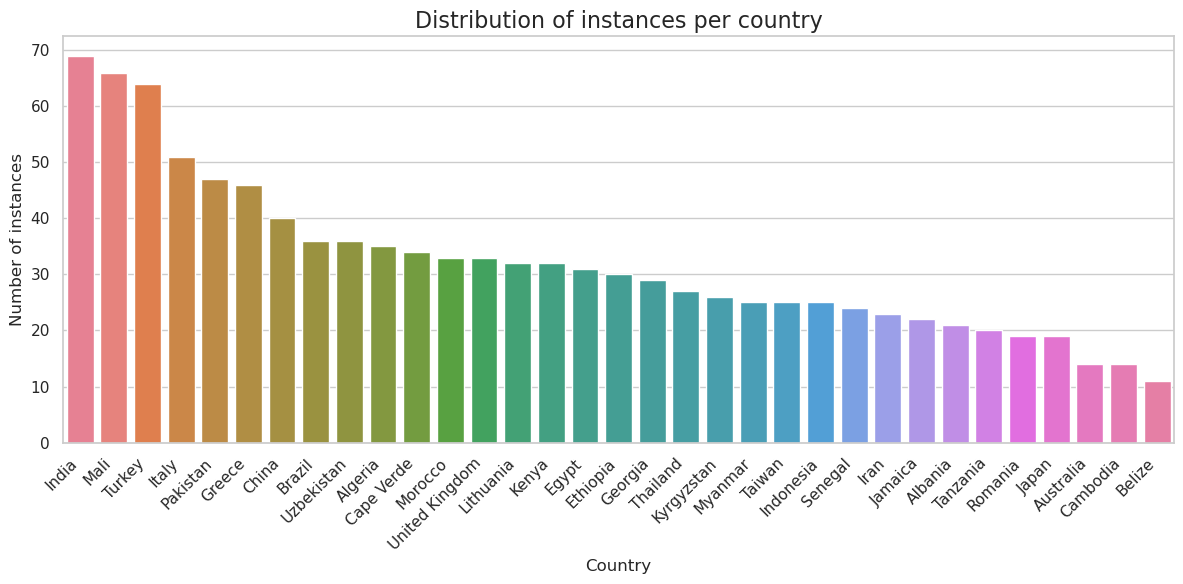

In [18]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(
    data=df_count,
    x='Country', 
    y='Instances', 
    hue = 'Country',
    legend = False
)
plt.title('Distribution of instances per country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of instances', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

We can see that the dataset is unbalanced.

## Visualise correlation

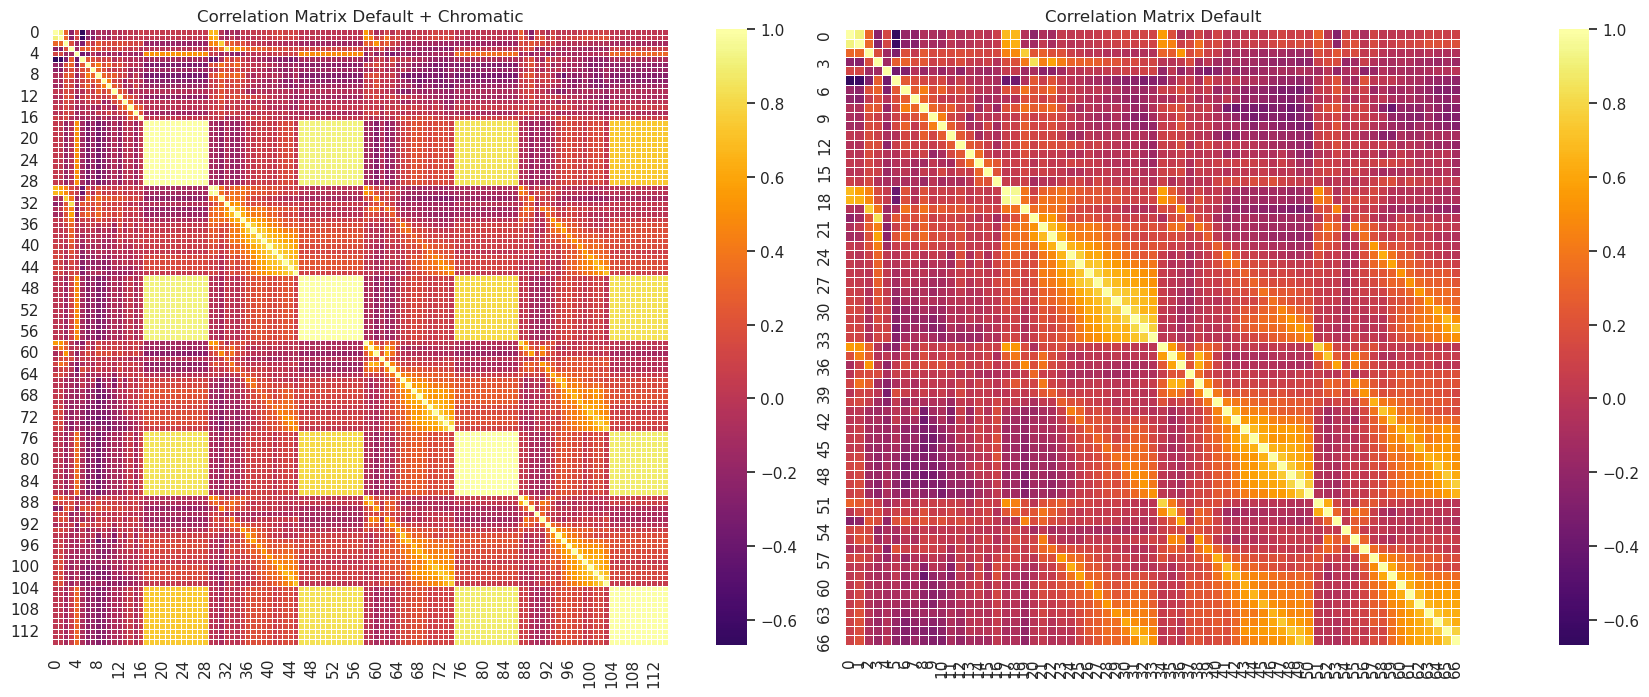

In [19]:
#Comparing correlation between variables with and without extra features
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.title(f'Correlation Matrix Default')
corr_matrix = df_68.iloc[:, 0:67].corr()
sns.heatmap(corr_matrix, cmap='inferno', center=0,square=True, linewidths=0.5)
plt.subplot(2, 2, 1)
plt.title(f'Correlation Matrix Default + Chromatic')
corr_matrix = df_116.iloc[:, 0:115].corr()
sns.heatmap(corr_matrix, cmap='inferno', center=0,square=True, linewidths=0.5)
plt.tight_layout()
plt.show()

It can be observed that some of the features are highly correlated, which can be problematic.

## PCA

In [20]:
#PCA for projection
pca_68 = PCA(n_components=2)
X_68_pca = pca_68.fit_transform(X_68)
#PCA to compute the variance kept by x components
pca_68_full = PCA()
pca_68_full.fit(X_68)
print(f"Variance explained by {2} components for default dataset: {pca_68.explained_variance_ratio_.sum():.4f}")
#With chromatic features
pca_116 = PCA(n_components=2)
X_116_pca = pca_116.fit_transform(X_116)
pca_116_full = PCA()
pca_116_full.fit(X_116)
print(f"Variance explained by {2} components for default + chromatic features dataset: {pca_116.explained_variance_ratio_.sum():.4f}")

Variance explained by 2 components for default dataset: 0.3180
Variance explained by 2 components for default + chromatic features dataset: 0.4951


In [21]:
#To get the point at 0.99
k_68_99 = np.where(np.cumsum(pca_68_full.explained_variance_ratio_) >= .99)[0][0]
per_68_99 = np.cumsum(pca_68_full.explained_variance_ratio_)[k_68_99]
k_68_99 = k_68_99+1

k_116_99 = np.where(np.cumsum(pca_116_full.explained_variance_ratio_) >= .99)[0][0]
per_116_99 = np.cumsum(pca_116_full.explained_variance_ratio_)[k_116_99]
k_116_99 = k_116_99+1

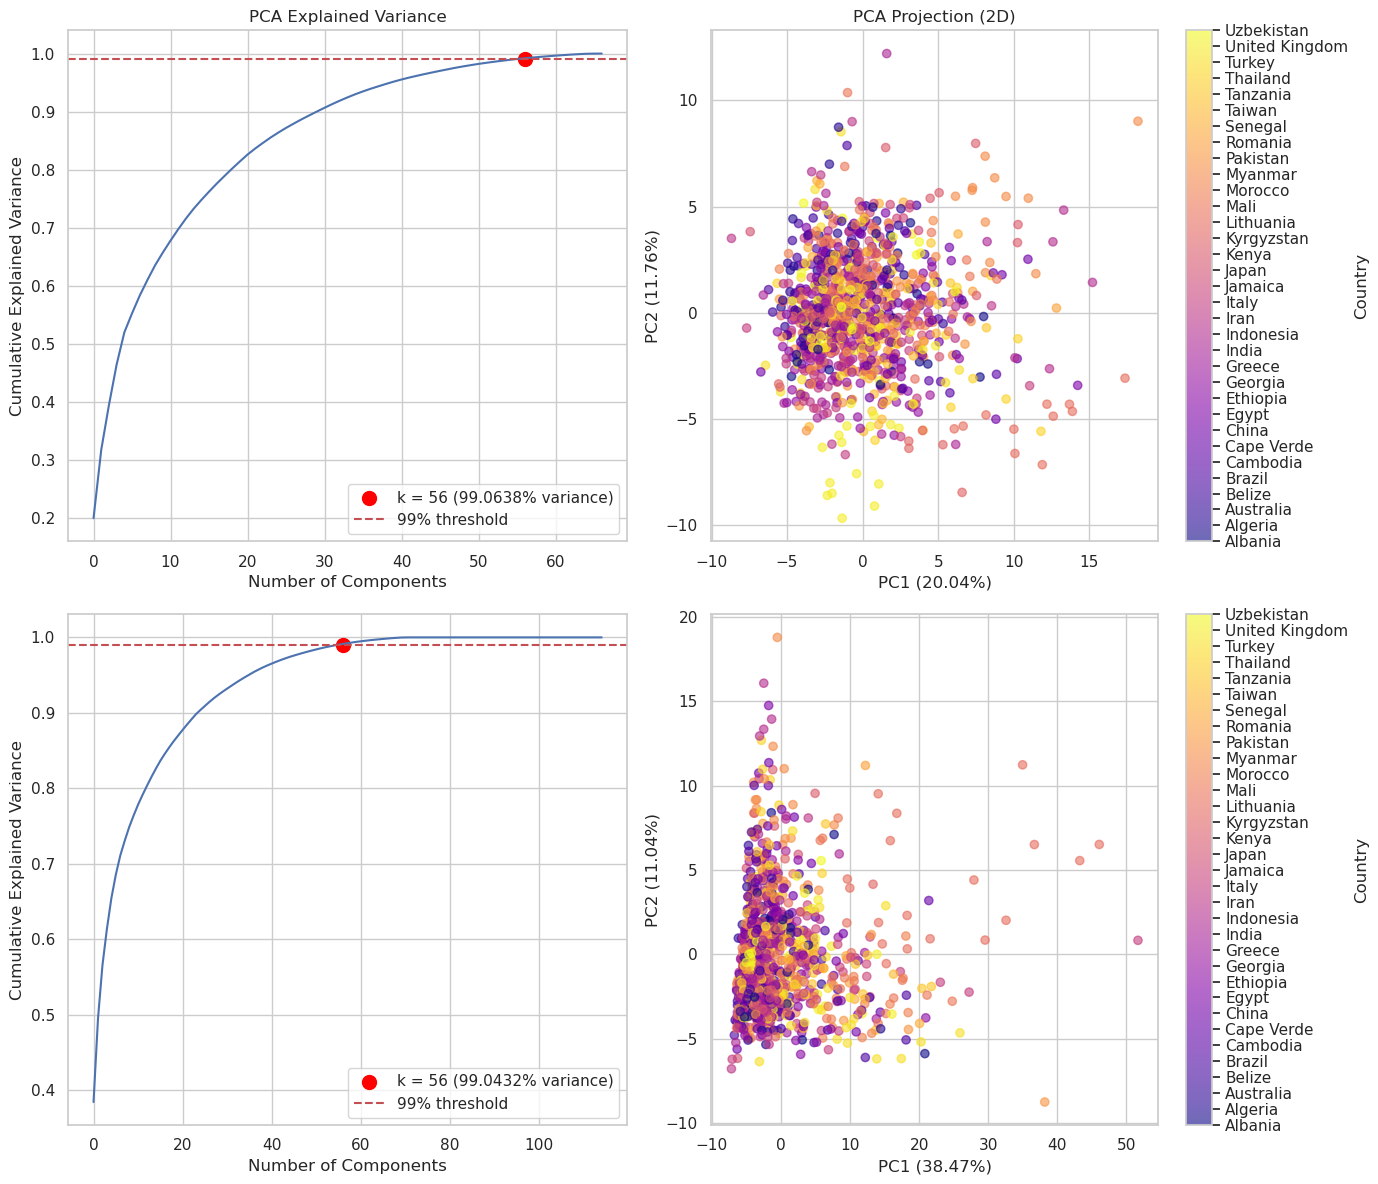

In [22]:
plt.figure(figsize=(14, 12))
plt.subplot(2, 2, 1)
plt.plot(np.cumsum(pca_68_full.explained_variance_ratio_))
plt.scatter(k_68_99, per_68_99, color='red', s=100, label=f'k = {k_68_99} ({per_68_99*100:.4f}% variance)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% threshold')
plt.legend()
plt.subplot(2, 2, 2)
scatter = plt.scatter(X_68_pca[:, 0], X_68_pca[:, 1], c= df_68['Country'].astype('category').cat.codes, cmap='plasma', alpha=0.6)
plt.xlabel(f'PC1 ({pca_68.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_68.explained_variance_ratio_[1]:.2%})')
plt.title('PCA Projection (2D)')
plt.grid(True)
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(df_68['Country'].astype('category').cat.categories)))
cbar.set_ticklabels(df_68['Country'].astype('category').cat.categories)
cbar.set_label('Country') 
plt.subplot(2, 2, 3)
plt.plot(np.cumsum(pca_116_full.explained_variance_ratio_))
plt.scatter(k_116_99, per_116_99, color='red', s=100, label=f'k = {k_116_99} ({per_116_99*100:.4f}% variance)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% threshold')
plt.legend()
plt.subplot(2, 2, 4)
scatter = plt.scatter(X_116_pca[:, 0], X_116_pca[:, 1], c= df_116['Country'].astype('category').cat.codes, cmap='plasma', alpha=0.6)
plt.xlabel(f'PC1 ({pca_116.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_116.explained_variance_ratio_[1]:.2%})')
plt.grid(True)
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(df_116['Country'].astype('category').cat.categories)))
cbar.set_ticklabels(df_116['Country'].astype('category').cat.categories)
cbar.set_label('Country') 
plt.tight_layout()
plt.show()

In [23]:
#Get the loadings for each variable
loadings_68 = pd.DataFrame(pca_68.components_.T, columns=["PC1", "PC2"], index=X_68.columns)
loadings_116 = pd.DataFrame(pca_116.components_.T, columns=["PC1", "PC2"], index=X_116.columns)

In [24]:
loadings_68.sort_values(by = "PC1")

,PC1,PC2
8,-0.100615,0.152270
9,-0.095824,0.090152
10,-0.083679,0.094869
6,-0.082535,0.130133
7,-0.070908,0.052673
...,...,...
48,0.202693,-0.113294
62,0.203701,-0.005067
66,0.207859,-0.056829
64,0.210532,-0.033442


## SVD

In [25]:
#Build matrices to use SVD decomposition
m_68 = df_68.iloc[:, 0:67].to_numpy(dtype=float, copy=False)
m_116 = df_116.iloc[:, 0:115].to_numpy(dtype=float, copy=False)
#SVD decomposition
U_68, S_68, Vh_68 = np.linalg.svd(m_68, full_matrices=True)
U_116, S_116, Vh_116 = np.linalg.svd(m_116, full_matrices=True)

In [26]:
#Get the variance by each k component
singular_68 = S_68**2
cumul_s_68 = np.cumsum(singular_68)
total_s_68 = np.sum(singular_68)
#Calculate the percentage of variance preserved for each k 
per_pre_68 = []
for i in range(len(cumul_s_68)):
    per_68 = cumul_s_68[i] / total_s_68 
    per_pre_68.append(per_68)
#To keep just the real part
k_list_68 = list(range(1, len(singular_68) + 1))
#Get the k where equal or greater than 99% of the variance is preserved
k_99_68 = np.where(np.array(per_pre_68) >= 0.99)[0][0]
per_99_68 = per_pre_68[k_99_68]
#Because the indices in python start in 0, we add a 1
k_99_68 = k_99_68+1

#+ Chromatic
singular_116 = S_116**2
cumul_s_116 = np.cumsum(singular_116)
total_s_116 = np.sum(singular_116)
#Calculate the percentage of variance preserved for each k 
per_pre_116 = []
for i in range(len(cumul_s_116)):
    per_116 = cumul_s_116[i] / total_s_116 
    per_pre_116.append(per_116)
#To keep just the real part
k_list_116 = list(range(1, len(singular_116) + 1))
#Get the k where equal or greater than 99% of the variance is preserved
k_99_116 = np.where(np.array(per_pre_116) >= 0.99)[0][0]
per_99_116 = per_pre_116[k_99_116]
#Because the indices in python start in 0, we add a 1
k_99_116 = k_99_116+1

In [27]:
error_68 = []
for k in range(len(k_list_68)):
    X_red = U_68[:, :k] @ np.diag(S_68[:k]) @ Vh_68[:k, :]
    err = np.linalg.norm(m_68 - X_red, ord='fro')
    error_68.append(err)

error_116 = []
for k in range(len(k_list_116)):
    X_red = U_116[:, :k] @ np.diag(S_116[:k]) @ Vh_116[:k, :]
    err = np.linalg.norm(m_116 - X_red, ord='fro')
    error_116.append(err)

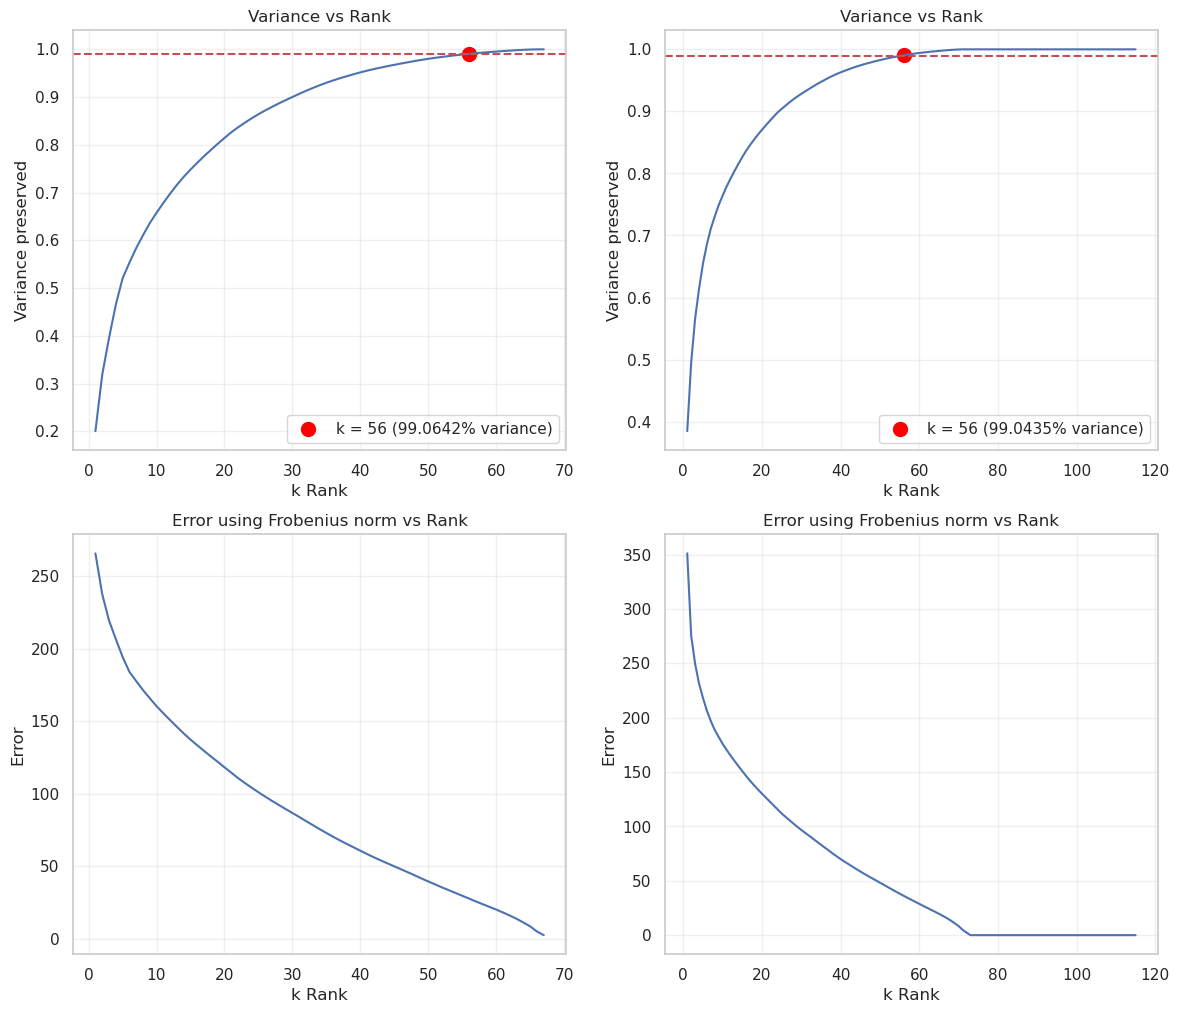

In [28]:
#4.1 Plot the variance preserved vs different k
plt.figure(figsize=(14, 12))
plt.subplot(2, 2, 1)
plt.plot(k_list_68, per_pre_68)
plt.scatter(k_99_68, per_99_68, color='red', s=100, label=f'k = {k_99_68} ({per_99_68*100:.4f}% variance)')
plt.xlabel('k Rank')
plt.ylabel('Variance preserved')
plt.title('Variance vs Rank')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% threshold')
plt.subplot(2, 2, 2)
plt.plot(k_list_116, per_pre_116)
plt.scatter(k_99_116, per_99_116, color='red', s=100, label=f'k = {k_99_116} ({per_99_116*100:.4f}% variance)')
plt.xlabel('k Rank')
plt.ylabel('Variance preserved')
plt.title('Variance vs Rank')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% threshold')
plt.subplot(2, 2, 3)
plt.plot(k_list_68, error_68)
plt.xlabel('k Rank')
plt.ylabel('Error')
plt.title('Error using Frobenius norm vs Rank')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 4)
plt.plot(k_list_116, error_116)
plt.xlabel('k Rank')
plt.ylabel('Error')
plt.title('Error using Frobenius norm vs Rank')
plt.grid(True, alpha=0.3)
plt.show()

As it can be observed for both datasets, de minimmun components/k which keeps at leats 99% of variance is 56

## Cluster visualisation
Just to see if there are any unseen structures.

In [29]:
tsne_68 = TSNE(n_components=2, perplexity=30, random_state=2000)
X_tsne_68 = tsne_68.fit_transform(X_68)
tsne_116 = TSNE(n_components=2, perplexity=30, random_state=2000)
X_tsne_116 = tsne_116.fit_transform(X_116)

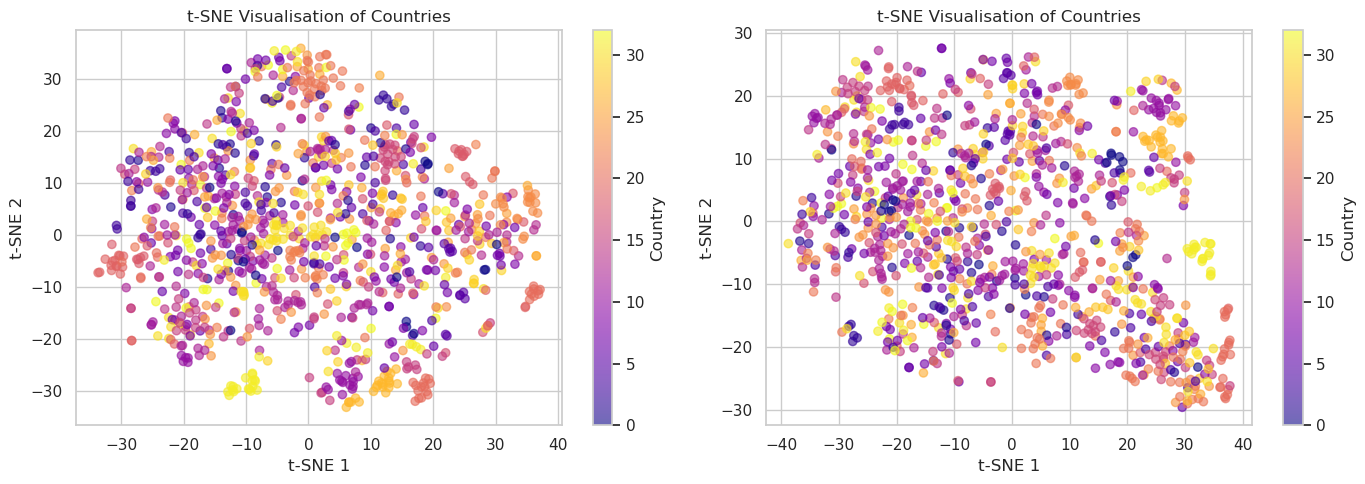

In [30]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_tsne_68[:, 0], X_tsne_68[:, 1], c=y_68, cmap='plasma', alpha=0.6)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualisation of Countries')
plt.colorbar(scatter, label='Country')
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne_116[:, 0], X_tsne_116[:, 1], c=y_116, cmap='plasma', alpha=0.6)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualisation of Countries')
plt.colorbar(scatter, label='Country')
plt.tight_layout()
plt.show()

## Models for 68 PCA SVD

### Train test split

In [31]:
#First, data split
X68_train, X68_test, y68_train, y68_test = train_test_split(X_68, y_68, test_size=0.2, random_state=2000, stratify=y_68)

In [32]:
#Establishing a minimum variance of 99% PCA
pca_68 = PCA(n_components=0.99)
X68_train_pca = pca_68.fit_transform(X68_train)  
X68_test_pca = pca_68.transform(X68_test)  
print(f'Number of components for train set: {pca_68.n_components_}\n Explained variance: {pca_68.explained_variance_ratio_.sum()}')

Number of components for train set: 56
 Explained variance: 0.9908511160350366


In [33]:
#Establishing a minimum variance of 99% SVD
svd68_temp = TruncatedSVD(n_components=min(X68_train.shape) - 1)
svd68_temp.fit(X68_train)
cumsum68_var = np.cumsum(svd68_temp.explained_variance_ratio_)
n_components68 = np.argmax(cumsum68_var >= 0.99) + 1
svd_68 = TruncatedSVD(n_components=n_components68)
X68_train_svd = svd_68.fit_transform(X68_train)
X68_test_svd = svd_68.transform(X68_test)
print(f'Rank for train set: {n_components68}\nExplained variance: {svd_68.explained_variance_ratio_.sum()}')

Rank for train set: 56
Explained variance: 0.9908509741158039


### Baseline

In [34]:
#FULL DATASET
dummy_68FULL = DummyClassifier(strategy='most_frequent')
#Train
start_trt_dummy_68FULL = time.time()
dummy_68FULL.fit(X68_train, y68_train)
trt_dummy_68FULL = time.time() - start_trt_dummy_68FULL
#Predict
start_prt_dummy_68FULL = time.time()
y_pred_dummy_68FULL = dummy_68FULL.predict(X68_test)
prt_dummy_68FULL = time.time() - start_prt_dummy_68FULL

In [35]:
#PCA DATASET
dummy_68PCA = DummyClassifier(strategy='most_frequent')
#Train
start_trt_dummy_68PCA = time.time()
dummy_68PCA.fit(X68_train_pca, y68_train)
trt_dummy_68PCA = time.time() - start_trt_dummy_68PCA
#Predict
start_prt_dummy_68PCA = time.time()
y_pred_dummy_68PCA = dummy_68PCA.predict(X68_test_pca)
prt_dummy_68PCA = time.time() - start_prt_dummy_68PCA

In [36]:
#SVD DATASET
dummy_68SVD = DummyClassifier(strategy='most_frequent')
#Train
start_trt_dummy_68SVD = time.time()
dummy_68SVD.fit(X68_train_svd, y68_train)
trt_dummy_68SVD = time.time() - start_trt_dummy_68SVD
#Predict
start_prt_dummy_68SVD = time.time()
y_pred_dummy_68SVD = dummy_68SVD.predict(X68_test_svd)
prt_dummy_68SVD = time.time() - start_prt_dummy_68SVD

In [37]:
#Metrics
#FULL
dummy_accuracy_68FULL = accuracy_score(y68_test, y_pred_dummy_68FULL)
dummy_accuracy_b_68FULL = balanced_accuracy_score(y68_test, y_pred_dummy_68FULL)
dummy_precision_68FULL = precision_score(y68_test, y_pred_dummy_68FULL, average='weighted', zero_division=0) 
dummy_recall_68FULL = recall_score(y68_test, y_pred_dummy_68FULL, average='weighted', zero_division=0)
dummy_f1_68FULL = f1_score(y68_test, y_pred_dummy_68FULL, average='weighted', zero_division=0)
#PCA
dummy_accuracy_68PCA = accuracy_score(y68_test, y_pred_dummy_68PCA)
dummy_accuracy_b_68PCA = balanced_accuracy_score(y68_test, y_pred_dummy_68PCA)
dummy_precision_68PCA = precision_score(y68_test, y_pred_dummy_68PCA, average='weighted', zero_division=0)
dummy_recall_68PCA = recall_score(y68_test, y_pred_dummy_68PCA, average='weighted', zero_division=0)
dummy_f1_68PCA = f1_score(y68_test, y_pred_dummy_68PCA, average='weighted', zero_division=0)
#SVD
dummy_accuracy_68SVD = accuracy_score(y68_test, y_pred_dummy_68SVD)
dummy_accuracy_b_68SVD = balanced_accuracy_score(y68_test, y_pred_dummy_68SVD)
dummy_precision_68SVD = precision_score(y68_test, y_pred_dummy_68SVD, average='weighted', zero_division=0)
dummy_recall_68SVD = recall_score(y68_test, y_pred_dummy_68SVD, average='weighted', zero_division=0)
dummy_f1_68SVD = f1_score(y68_test, y_pred_dummy_68SVD, average='weighted', zero_division=0)

In [38]:
pedummy_DUMMY68 = pd.DataFrame(data={'Dataset':['Full','PCA', 'SVD'],'Training time': [trt_dummy_68FULL, trt_dummy_68SVD, trt_dummy_68PCA], 'Prediction time': [prt_dummy_68FULL, prt_dummy_68PCA, prt_dummy_68SVD], 'Accuracy': [dummy_accuracy_68FULL, dummy_accuracy_68PCA, dummy_accuracy_68SVD],'Balanced Accuracy':[dummy_accuracy_b_68FULL, dummy_accuracy_b_68PCA, dummy_accuracy_b_68SVD], 'Precision':[dummy_precision_68FULL, dummy_precision_68PCA, dummy_precision_68SVD], 'Recall':[dummy_recall_68FULL, dummy_recall_68PCA, dummy_recall_68SVD], 'F1':[dummy_f1_68FULL, dummy_f1_68PCA, dummy_f1_68SVD] })
pedummy_DUMMY68

,Dataset,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.000449,0.000140,0.066038,0.030303,0.004361,0.066038,0.008182
1,PCA,0.000374,0.000148,0.066038,0.030303,0.004361,0.066038,0.008182
2,SVD,0.000483,0.000100,0.066038,0.030303,0.004361,0.066038,0.008182


### Random Forest 

In [39]:
#FULL DATASET
rf_68FULL = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1)
#Train
start_trt_rf_68FULL = time.time()
rf_68FULL.fit(X68_train, y68_train)
trt_rf_68FULL = time.time() - start_trt_rf_68FULL
#Predict
start_prt_rf_68FULL = time.time()
y_pred_rf_68FULL = rf_68FULL.predict(X68_test)
prt_rf_68FULL = time.time() - start_prt_rf_68FULL

In [40]:
#PCA DATASET
rf_68PCA = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1)
#Train
start_trt_rf_68PCA = time.time()
rf_68PCA.fit(X68_train_pca, y68_train)
trt_rf_68PCA = time.time() - start_trt_rf_68PCA
#Predict
start_prt_rf_68PCA = time.time()
y_pred_rf_68PCA = rf_68PCA.predict(X68_test_pca)
prt_rf_68PCA = time.time() - start_prt_rf_68PCA

In [41]:
#SVD DATASET
rf_68SVD = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1)
#Train
start_trt_rf_68SVD = time.time()
rf_68SVD.fit(X68_train_svd, y68_train)
trt_rf_68SVD = time.time() - start_trt_rf_68SVD
#Predict
start_prt_rf_68SVD = time.time()
y_pred_rf_68SVD = rf_68SVD.predict(X68_test_svd)
prt_rf_68SVD = time.time() - start_prt_rf_68SVD

In [42]:
#Metrics
#FULL
rf_accuracy_68FULL = accuracy_score(y68_test, y_pred_rf_68FULL)
rf_accuracy_b_68FULL = balanced_accuracy_score(y68_test, y_pred_rf_68FULL)
rf_precision_68FULL = precision_score(y68_test, y_pred_rf_68FULL, average='weighted', zero_division=0) 
rf_recall_68FULL = recall_score(y68_test, y_pred_rf_68FULL, average='weighted', zero_division=0)
rf_f1_68FULL = f1_score(y68_test, y_pred_rf_68FULL, average='weighted', zero_division=0)
#PCA
rf_accuracy_68PCA = accuracy_score(y68_test, y_pred_rf_68PCA)
rf_accuracy_b_68PCA = balanced_accuracy_score(y68_test, y_pred_rf_68PCA)
rf_precision_68PCA = precision_score(y68_test, y_pred_rf_68PCA, average='weighted', zero_division=0)
rf_recall_68PCA = recall_score(y68_test, y_pred_rf_68PCA, average='weighted', zero_division=0)
rf_f1_68PCA = f1_score(y68_test, y_pred_rf_68PCA, average='weighted', zero_division=0)
#SVD
rf_accuracy_68SVD = accuracy_score(y68_test, y_pred_rf_68SVD)
rf_accuracy_b_68SVD = balanced_accuracy_score(y68_test, y_pred_rf_68SVD)
rf_precision_68SVD = precision_score(y68_test, y_pred_rf_68SVD, average='weighted', zero_division=0)
rf_recall_68SVD = recall_score(y68_test, y_pred_rf_68SVD, average='weighted', zero_division=0)
rf_f1_68SVD = f1_score(y68_test, y_pred_rf_68SVD, average='weighted', zero_division=0)

In [43]:
perf_RF68 = pd.DataFrame(data={'Dataset':['Full','PCA', 'SVD'],'Training time': [trt_rf_68FULL, trt_rf_68SVD, trt_rf_68PCA], 'Prediction time': [prt_rf_68FULL, prt_rf_68PCA, prt_rf_68SVD], 'Accuracy': [rf_accuracy_68FULL, rf_accuracy_68PCA, rf_accuracy_68SVD],'Balanced Accuracy':[rf_accuracy_b_68FULL, rf_accuracy_b_68PCA, rf_accuracy_b_68SVD], 'Precision':[rf_precision_68FULL, rf_precision_68PCA, rf_precision_68SVD], 'Recall':[rf_recall_68FULL, rf_recall_68PCA, rf_recall_68SVD], 'F1':[rf_f1_68FULL, rf_f1_68PCA, rf_f1_68SVD] })
perf_RF68

,Dataset,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.524808,0.188703,0.443396,0.466826,0.474032,0.443396,0.411552
1,PCA,0.421515,0.054745,0.367925,0.389959,0.351126,0.367925,0.341347
2,SVD,0.464063,0.051702,0.386792,0.406069,0.390860,0.386792,0.365151


### kNN

In [44]:
#Parameters to try 
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 10, 11, 15, 19],
              'metric': ['euclidean', 'manhattan', 'minkowski'],
              'weights': ['uniform', 'distance']}

In [45]:
#FULL DATASET
#Grid search for knn
start_grid_knn_68FULL = time.time()
knn_grid_68FULL = GridSearchCV(KNeighborsClassifier(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
knn_grid_68FULL.fit(X68_train, y68_train)
grid_knn_68FULL  = time.time() - start_grid_knn_68FULL
print(f'Grid search time for knn: {grid_knn_68FULL}')
#To show the best parameters obtained
knn_grid_68FULL.best_params_
#USing best parameters
knn_68FULL = KNeighborsClassifier(**knn_grid_68FULL.best_params_)
print(f'Best parameters:{knn_grid_68FULL.best_params_} \nTime for Grid search: {grid_knn_68FULL}')
#Train
start_trt_knn_68FULL = time.time()
knn_68FULL.fit(X68_train, y68_train)
trt_knn_68FULL = time.time() - start_trt_knn_68FULL
#Predict
start_prt_knn_68FULL = time.time()
y_pred_knn_68FULL = knn_68FULL.predict(X68_test)
prt_knn_68FULL = time.time() - start_prt_knn_68FULL

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search time for knn: 1.8005297183990479
Best parameters:{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'} 
Time for Grid search: 1.8005297183990479


In [46]:
#PCA DATASET
#Grid search for knn
start_grid_knn_68PCA = time.time()
knn_grid_68PCA = GridSearchCV(KNeighborsClassifier(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
knn_grid_68PCA.fit(X68_train_pca, y68_train)
grid_knn_68PCA  = time.time() - start_grid_knn_68PCA
print(f'Grid search time for knn: {grid_knn_68PCA}')
#To show the best parameters obtained
knn_grid_68PCA.best_params_
#USing best parameters
knn_68PCA = KNeighborsClassifier(**knn_grid_68PCA.best_params_)
print(f'Best parameters:{knn_grid_68PCA.best_params_} \nTime for Grid search: {grid_knn_68PCA}')
#Train
start_trt_knn_68PCA = time.time()
knn_68PCA.fit(X68_train_pca, y68_train)
trt_knn_68PCA = time.time() - start_trt_knn_68PCA
#Predict
start_prt_knn_68PCA = time.time()
y_pred_knn_68PCA = knn_68PCA.predict(X68_test_pca)
prt_knn_68PCA = time.time() - start_prt_knn_68PCA

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search time for knn: 0.13607025146484375
Best parameters:{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'} 
Time for Grid search: 0.13607025146484375


In [47]:
#SVD DATASET
#Grid search for knn
start_grid_knn_68SVD = time.time()
knn_grid_68SVD = GridSearchCV(KNeighborsClassifier(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
knn_grid_68SVD.fit(X68_train_svd, y68_train)
grid_knn_68SVD  = time.time() - start_grid_knn_68SVD
print(f'Grid search time for knn: {grid_knn_68SVD}')
#To show the best parameters obtained
knn_grid_68SVD.best_params_
#USing best parameters
knn_68SVD = KNeighborsClassifier(**knn_grid_68SVD.best_params_)
print(f'Best parameters:{knn_grid_68SVD.best_params_} \nTime for Grid search: {grid_knn_68SVD}')
#Train
start_trt_knn_68SVD = time.time()
knn_68SVD.fit(X68_train_svd, y68_train)
trt_knn_68SVD = time.time() - start_trt_knn_68SVD
#Predict
start_prt_knn_68SVD = time.time()
y_pred_knn_68SVD = knn_68SVD.predict(X68_test_svd)
prt_knn_68SVD = time.time() - start_prt_knn_68SVD

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search time for knn: 0.13817524909973145
Best parameters:{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'} 
Time for Grid search: 0.13817524909973145


In [48]:
#Metrics
#FULL
knn_accuracy_68FULL = accuracy_score(y68_test, y_pred_knn_68FULL)
knn_accuracy_b_68FULL = balanced_accuracy_score(y68_test, y_pred_knn_68FULL)
knn_precision_68FULL = precision_score(y68_test, y_pred_knn_68FULL, average='weighted', zero_division=0)
knn_recall_68FULL = recall_score(y68_test, y_pred_knn_68FULL, average='weighted', zero_division=0)
knn_f1_68FULL = f1_score(y68_test, y_pred_knn_68FULL, average='weighted', zero_division=0)
#PCA
knn_accuracy_68PCA = accuracy_score(y68_test, y_pred_knn_68PCA)
knn_accuracy_b_68PCA = balanced_accuracy_score(y68_test, y_pred_knn_68PCA)
knn_precision_68PCA = precision_score(y68_test, y_pred_knn_68PCA, average='weighted', zero_division=0)
knn_recall_68PCA = recall_score(y68_test, y_pred_knn_68PCA, average='weighted', zero_division=0)
knn_f1_68PCA = f1_score(y68_test, y_pred_knn_68PCA, average='weighted', zero_division=0)
#SVD
knn_accuracy_68SVD = accuracy_score(y68_test, y_pred_knn_68SVD)
knn_accuracy_b_68SVD = balanced_accuracy_score(y68_test, y_pred_knn_68SVD)
knn_precision_68SVD = precision_score(y68_test, y_pred_knn_68SVD, average='weighted', zero_division=0)
knn_recall_68SVD = recall_score(y68_test, y_pred_knn_68SVD, average='weighted', zero_division=0)
knn_f1_68SVD = f1_score(y68_test, y_pred_knn_68SVD, average='weighted', zero_division=0)

In [49]:
perf_KNN68 = pd.DataFrame(data={'Dataset':['Full','PCA', 'SVD'],'Training time': [trt_knn_68FULL, trt_knn_68SVD, trt_knn_68PCA], 'Prediction time': [prt_knn_68FULL, prt_knn_68PCA, prt_knn_68SVD], 'Accuracy': [knn_accuracy_68FULL, knn_accuracy_68PCA, knn_accuracy_68SVD],'Balanced Accuracy':[knn_accuracy_b_68FULL, knn_accuracy_b_68PCA, knn_accuracy_b_68SVD], 'Precision':[knn_precision_68FULL, knn_precision_68PCA, knn_precision_68SVD], 'Recall':[knn_recall_68FULL, knn_recall_68PCA, knn_recall_68SVD], 'F1':[knn_f1_68FULL, knn_f1_68PCA, knn_f1_68SVD] })
perf_KNN68

,Dataset,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.001977,0.142591,0.40566,0.421387,0.392349,0.40566,0.385706
1,PCA,0.000663,0.085242,0.40566,0.403877,0.444843,0.40566,0.388640
2,SVD,0.000641,0.076668,0.40566,0.403877,0.444843,0.40566,0.388640


### SVM

In [50]:
#Parameters to try
param_grid = {'C': [0.1, 1, 10],'gamma': ['scale', 0.001, 0.01],'kernel': ['rbf', 'linear']}

In [51]:
#FULL DATASET
#Grid search for svm
start_grid_svm_68FULL = time.time()
svm_grid_68FULL = GridSearchCV(SVC(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
svm_grid_68FULL.fit(X68_train, y68_train)
grid_svm_68FULL  = time.time() - start_grid_svm_68FULL
print(f'Grid search time for svm: {grid_svm_68FULL}')
#To show the best parameters obtained
svm_grid_68FULL.best_params_
#USing best parameters
svm_68FULL = SVC(**svm_grid_68FULL.best_params_, verbose=True)
print(f'Best parameters:{svm_grid_68FULL.best_params_} \nTime for Grid search: {grid_svm_68FULL}')
#Train
start_trt_svm_68FULL = time.time()
svm_68FULL.fit(X68_train, y68_train)
trt_svm_68FULL = time.time() - start_trt_svm_68FULL
#Predict
start_prt_svm_68FULL = time.time()
y_pred_svm_68FULL = svm_68FULL.predict(X68_test)
prt_svm_68FULL = time.time() - start_prt_svm_68FULL

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search time for svm: 0.268845796585083
Best parameters:{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} 
Time for Grid search: 0.268845796585083
[LibSVM].*.*
optimization finished, #iter = 106
obj = -43.654886, rho = 0.361891
nSV = 32, nBSV = 0
.*.*
optimization finished, #iter = 57
obj = -10.827537, rho = 0.340046
nSV = 23, nBSV = 0
.*
optimization finished, #iter = 43
obj = -5.601006, rho = -0.439117
nSV = 19, nBSV = 0
.*.*
optimization finished, #iter = 130
obj = -42.286013, rho = 0.069196
nSV = 36, nBSV = 0
.*.*
optimization finished, #iter = 56
obj = -10.793163, rho = -0.427145
nSV = 22, nBSV = 0
.*.*
optimization finished, #iter = 105
obj = -31.759893, rho = -0.001165
nSV = 35, nBSV = 0
.*.*
optimization finished, #iter = 112
obj = -28.364014, rho = 0.765356
nSV = 41, nBSV = 0
.*.*
optimization finished, #iter = 102
obj = -47.236213, rho = 0.465512
nSV = 36, nBSV = 1
.*.*
optimization finished, #iter = 84
obj = -24.357695

In [52]:
#PCA DATASET
#Grid search for svm
start_grid_svm_68PCA = time.time()
svm_grid_68PCA = GridSearchCV(SVC(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
svm_grid_68PCA.fit(X68_train_pca, y68_train)
grid_svm_68PCA  = time.time() - start_grid_svm_68PCA
print(f'Grid search time for svm: {grid_svm_68PCA}')
#To show the best parameters obtained
svm_grid_68PCA.best_params_
#USing best parameters
svm_68PCA = SVC(**svm_grid_68PCA.best_params_)
print(f'Best parameters:{svm_grid_68PCA.best_params_} \nTime for Grid search: {grid_svm_68PCA}')
#Train
start_trt_svm_68PCA = time.time()
svm_68PCA.fit(X68_train_pca, y68_train)
trt_svm_68PCA = time.time() - start_trt_svm_68PCA
#Predict
start_prt_svm_68PCA = time.time()
y_pred_svm_68PCA = svm_68PCA.predict(X68_test_pca)
prt_svm_68PCA = time.time() - start_prt_svm_68PCA

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search time for svm: 0.2447514533996582
Best parameters:{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} 
Time for Grid search: 0.2447514533996582


In [53]:
#SVD DATASET
#Grid search for svm
start_grid_svm_68SVD = time.time()
svm_grid_68SVD = GridSearchCV(SVC(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
svm_grid_68SVD.fit(X68_train_svd, y68_train)
grid_svm_68SVD  = time.time() - start_grid_svm_68SVD
print(f'Grid search time for svm: {grid_svm_68SVD}')
#To show the best parameters obtained
svm_grid_68SVD.best_params_
#USing best parameters
svm_68SVD = SVC(**svm_grid_68SVD.best_params_)
print(f'Best parameters:{svm_grid_68SVD.best_params_} \nTime for Grid search: {grid_svm_68SVD}')
#Train
start_trt_svm_68SVD = time.time()
svm_68SVD.fit(X68_train_svd, y68_train)
trt_svm_68SVD = time.time() - start_trt_svm_68SVD
#Predict
start_prt_svm_68SVD = time.time()
y_pred_svm_68SVD = svm_68SVD.predict(X68_test_svd)
prt_svm_68SVD = time.time() - start_prt_svm_68SVD

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search time for svm: 0.25656628608703613
Best parameters:{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} 
Time for Grid search: 0.25656628608703613


In [54]:
#Metrics
#FULL
svm_accuracy_68FULL = accuracy_score(y68_test, y_pred_svm_68FULL)
svm_accuracy_b_68FULL = balanced_accuracy_score(y68_test, y_pred_svm_68FULL)
svm_precision_68FULL = precision_score(y68_test, y_pred_svm_68FULL, average='weighted', zero_division=0) 
svm_recall_68FULL = recall_score(y68_test, y_pred_svm_68FULL, average='weighted', zero_division=0)
svm_f1_68FULL = f1_score(y68_test, y_pred_svm_68FULL, average='weighted', zero_division=0)
#PCA
svm_accuracy_68PCA = accuracy_score(y68_test, y_pred_svm_68PCA)
svm_accuracy_b_68PCA = balanced_accuracy_score(y68_test, y_pred_svm_68PCA)
svm_precision_68PCA = precision_score(y68_test, y_pred_svm_68PCA, average='weighted', zero_division=0)
svm_recall_68PCA = recall_score(y68_test, y_pred_svm_68PCA, average='weighted', zero_division=0)
svm_f1_68PCA = f1_score(y68_test, y_pred_svm_68PCA, average='weighted', zero_division=0)
#SVD
svm_accuracy_68SVD = accuracy_score(y68_test, y_pred_svm_68SVD)
svm_accuracy_b_68SVD = balanced_accuracy_score(y68_test, y_pred_svm_68SVD)
svm_precision_68SVD = precision_score(y68_test, y_pred_svm_68SVD, average='weighted', zero_division=0)
svm_recall_68SVD = recall_score(y68_test, y_pred_svm_68SVD, average='weighted', zero_division=0)
svm_f1_68SVD = f1_score(y68_test, y_pred_svm_68SVD, average='weighted', zero_division=0)

In [55]:
perf_SVM68 = pd.DataFrame(data={'Dataset':['Full','PCA', 'SVD'],'Training time': [trt_svm_68FULL, trt_svm_68SVD, trt_svm_68PCA], 'Prediction time': [prt_svm_68FULL, prt_svm_68PCA, prt_svm_68SVD], 'Accuracy': [svm_accuracy_68FULL, svm_accuracy_68PCA, svm_accuracy_68SVD],'Balanced Accuracy':[svm_accuracy_b_68FULL, svm_accuracy_b_68PCA, svm_accuracy_b_68SVD], 'Precision':[svm_precision_68FULL, svm_precision_68PCA, svm_precision_68SVD], 'Recall':[svm_recall_68FULL, svm_recall_68PCA, svm_recall_68SVD], 'F1':[svm_f1_68FULL, svm_f1_68PCA, svm_f1_68SVD] })
perf_SVM68

,Dataset,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.076961,0.016211,0.438679,0.463863,0.466381,0.438679,0.442120
1,PCA,0.071541,0.015615,0.438679,0.459592,0.459307,0.438679,0.438701
2,SVD,0.070705,0.015549,0.438679,0.459592,0.459307,0.438679,0.438701


## Models for 116 PCA SVD

### Train test split

In [56]:
X116_train, X116_test, y116_train, y116_test = train_test_split(X_116, y_116, test_size=0.2, random_state=2000, stratify=y_116)

In [57]:
#Establishing a minimum variance of 99% PCA
pca_116 = PCA(n_components=0.99)
X116_train_pca = pca_116.fit_transform(X116_train)  
X116_test_pca = pca_116.transform(X116_test)  
print(f'Number of components for train set: {pca_116.n_components_}\n Explained variance: {pca_116.explained_variance_ratio_.sum()}')

Number of components for train set: 56
 Explained variance: 0.9907519788314192


In [58]:
#Establishing a minimum variance of 99% SVD
svd116_temp = TruncatedSVD(n_components=min(X116_train.shape) - 1)
svd116_temp.fit(X116_train)
cumsum116_var = np.cumsum(svd116_temp.explained_variance_ratio_)
n_components116 = np.argmax(cumsum116_var >= 0.99) + 1
svd_116 = TruncatedSVD(n_components=n_components116)
X116_train_svd = svd_116.fit_transform(X116_train)
X116_test_svd = svd_116.transform(X116_test)
print(f'Rank for train set: {n_components116}\nExplained variance: {svd_116.explained_variance_ratio_.sum()}')

Rank for train set: 56
Explained variance: 0.9907517472176127


### Baseline

In [59]:
#FULL DATASET
dummy_116FULL = DummyClassifier(strategy='most_frequent')
#Train
start_trt_dummy_116FULL = time.time()
dummy_116FULL.fit(X116_train, y116_train)
trt_dummy_116FULL = time.time() - start_trt_dummy_116FULL
#Predict
start_prt_dummy_116FULL = time.time()
y_pred_dummy_116FULL = dummy_116FULL.predict(X116_test)
prt_dummy_116FULL = time.time() - start_prt_dummy_116FULL

In [60]:
#PCA DATASET
dummy_116PCA = DummyClassifier(strategy='most_frequent')
#Train
start_trt_dummy_116PCA = time.time()
dummy_116PCA.fit(X116_train_pca, y116_train)
trt_dummy_116PCA = time.time() - start_trt_dummy_116PCA
#Predict
start_prt_dummy_116PCA = time.time()
y_pred_dummy_116PCA = dummy_116PCA.predict(X116_test_pca)
prt_dummy_116PCA = time.time() - start_prt_dummy_116PCA

In [61]:
#SVD DATASET
dummy_116SVD = DummyClassifier(strategy='most_frequent')
#Train
start_trt_dummy_116SVD = time.time()
dummy_116SVD.fit(X116_train_svd, y116_train)
trt_dummy_116SVD = time.time() - start_trt_dummy_116SVD
#Predict
start_prt_dummy_116SVD = time.time()
y_pred_dummy_116SVD = dummy_116SVD.predict(X116_test_svd)
prt_dummy_116SVD = time.time() - start_prt_dummy_116SVD

In [62]:
#Metrics
#FULL
dummy_accuracy_116FULL = accuracy_score(y116_test, y_pred_dummy_116FULL)
dummy_accuracy_b_116FULL = balanced_accuracy_score(y116_test, y_pred_dummy_116FULL)
dummy_precision_116FULL = precision_score(y116_test, y_pred_dummy_116FULL, average='weighted', zero_division=0) 
dummy_recall_116FULL = recall_score(y116_test, y_pred_dummy_116FULL, average='weighted', zero_division=0)
dummy_f1_116FULL = f1_score(y116_test, y_pred_dummy_116FULL, average='weighted', zero_division=0)
#PCA
dummy_accuracy_116PCA = accuracy_score(y116_test, y_pred_dummy_116PCA)
dummy_accuracy_b_116PCA = balanced_accuracy_score(y116_test, y_pred_dummy_116PCA)
dummy_precision_116PCA = precision_score(y116_test, y_pred_dummy_116PCA, average='weighted', zero_division=0)
dummy_recall_116PCA = recall_score(y116_test, y_pred_dummy_116PCA, average='weighted', zero_division=0)
dummy_f1_116PCA = f1_score(y116_test, y_pred_dummy_116PCA, average='weighted', zero_division=0)
#SVD
dummy_accuracy_116SVD = accuracy_score(y116_test, y_pred_dummy_116SVD)
dummy_accuracy_b_116SVD = balanced_accuracy_score(y116_test, y_pred_dummy_116SVD)
dummy_precision_116SVD = precision_score(y116_test, y_pred_dummy_116SVD, average='weighted', zero_division=0)
dummy_recall_116SVD = recall_score(y116_test, y_pred_dummy_116SVD, average='weighted', zero_division=0)
dummy_f1_116SVD = f1_score(y116_test, y_pred_dummy_116SVD, average='weighted', zero_division=0)

In [63]:
pedummy_DUMMY116 = pd.DataFrame(data={'Classifier':['Full','PCA', 'SVD'],'Training time': [trt_dummy_116FULL, trt_dummy_116SVD, trt_dummy_116PCA], 'Prediction time': [prt_dummy_116FULL, prt_dummy_116PCA, prt_dummy_116SVD], 'Accuracy': [dummy_accuracy_116FULL, dummy_accuracy_116PCA, dummy_accuracy_116SVD],'Balanced Accuracy':[dummy_accuracy_b_116FULL, dummy_accuracy_b_116PCA, dummy_accuracy_b_116SVD], 'Precision':[dummy_precision_116FULL, dummy_precision_116PCA, dummy_precision_116SVD], 'Recall':[dummy_recall_116FULL, dummy_recall_116PCA, dummy_recall_116SVD], 'F1':[dummy_f1_116FULL, dummy_f1_116PCA, dummy_f1_116SVD] })
pedummy_DUMMY116

,Classifier,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.001020,0.000149,0.066038,0.030303,0.004361,0.066038,0.008182
1,PCA,0.000620,0.000123,0.066038,0.030303,0.004361,0.066038,0.008182
2,SVD,0.000701,0.000109,0.066038,0.030303,0.004361,0.066038,0.008182


### Random Forest 

In [64]:
#FULL DATASET
rf_116FULL = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1)
#Train
start_trt_rf_116FULL = time.time()
rf_116FULL.fit(X116_train, y116_train)
trt_rf_116FULL = time.time() - start_trt_rf_116FULL
#Predict
start_prt_rf_116FULL = time.time()
y_pred_rf_116FULL = rf_116FULL.predict(X116_test)
prt_rf_116FULL = time.time() - start_prt_rf_116FULL

In [65]:
#PCA DATASET
rf_116PCA = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1)
#Train
start_trt_rf_116PCA = time.time()
rf_116PCA.fit(X116_train_pca, y116_train)
trt_rf_116PCA = time.time() - start_trt_rf_116PCA
#Predict
start_prt_rf_116PCA = time.time()
y_pred_rf_116PCA = rf_116PCA.predict(X116_test_pca)
prt_rf_116PCA = time.time() - start_prt_rf_116PCA

In [66]:
#SVD DATASET
rf_116SVD = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1)
#Train
start_trt_rf_116SVD = time.time()
rf_116SVD.fit(X116_train_svd, y116_train)
trt_rf_116SVD = time.time() - start_trt_rf_116SVD
#Predict
start_prt_rf_116SVD = time.time()
y_pred_rf_116SVD = rf_116SVD.predict(X116_test_svd)
prt_rf_116SVD = time.time() - start_prt_rf_116SVD

In [67]:
#Metrics
#FULL
rf_accuracy_116FULL = accuracy_score(y116_test, y_pred_rf_116FULL)
rf_accuracy_b_116FULL = balanced_accuracy_score(y116_test, y_pred_rf_116FULL)
rf_precision_116FULL = precision_score(y116_test, y_pred_rf_116FULL, average='weighted', zero_division=0) 
rf_recall_116FULL = recall_score(y116_test, y_pred_rf_116FULL, average='weighted', zero_division=0)
rf_f1_116FULL = f1_score(y116_test, y_pred_rf_116FULL, average='weighted', zero_division=0)
#PCA
rf_accuracy_116PCA = accuracy_score(y116_test, y_pred_rf_116PCA)
rf_accuracy_b_116PCA = balanced_accuracy_score(y116_test, y_pred_rf_116PCA)
rf_precision_116PCA = precision_score(y116_test, y_pred_rf_116PCA, average='weighted', zero_division=0)
rf_recall_116PCA = recall_score(y116_test, y_pred_rf_116PCA, average='weighted', zero_division=0)
rf_f1_116PCA = f1_score(y116_test, y_pred_rf_116PCA, average='weighted', zero_division=0)
#SVD
rf_accuracy_116SVD = accuracy_score(y116_test, y_pred_rf_116SVD)
rf_accuracy_b_116SVD = balanced_accuracy_score(y116_test, y_pred_rf_116SVD)
rf_precision_116SVD = precision_score(y116_test, y_pred_rf_116SVD, average='weighted', zero_division=0)
rf_recall_116SVD = recall_score(y116_test, y_pred_rf_116SVD, average='weighted', zero_division=0)
rf_f1_116SVD = f1_score(y116_test, y_pred_rf_116SVD, average='weighted', zero_division=0)

In [68]:
perf_RF116 = pd.DataFrame(data={'Dataset':['Full','PCA', 'SVD'],'Training time': [trt_rf_116FULL, trt_rf_116SVD, trt_rf_116PCA], 'Prediction time': [prt_rf_116FULL, prt_rf_116PCA, prt_rf_116SVD], 'Accuracy': [rf_accuracy_116FULL, rf_accuracy_116PCA, rf_accuracy_116SVD],'Balanced Accuracy':[rf_accuracy_b_116FULL, rf_accuracy_b_116PCA, rf_accuracy_b_116SVD], 'Precision':[rf_precision_116FULL, rf_precision_116PCA, rf_precision_116SVD], 'Recall':[rf_recall_116FULL, rf_recall_116PCA, rf_recall_116SVD], 'F1':[rf_f1_116FULL, rf_f1_116PCA, rf_f1_116SVD] })
perf_RF116

,Dataset,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.545788,0.053740,0.457547,0.482879,0.490904,0.457547,0.422361
1,PCA,0.422643,0.050724,0.410377,0.448060,0.422769,0.410377,0.382503
2,SVD,0.419568,0.069600,0.382075,0.411119,0.365401,0.382075,0.349664


### kNN

In [69]:
#Parameters to try 
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 10, 11, 15, 19],
              'metric': ['euclidean', 'manhattan', 'minkowski'],
              'weights': ['uniform', 'distance']}

In [70]:
#FULL DATASET
#Grid search for knn
start_grid_knn_116FULL = time.time()
knn_grid_116FULL = GridSearchCV(KNeighborsClassifier(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
knn_grid_116FULL.fit(X116_train, y116_train)
grid_knn_116FULL  = time.time() - start_grid_knn_116FULL
print(f'Grid search time for knn: {grid_knn_116FULL}')
#To show the best parameters obtained
knn_grid_116FULL.best_params_
#USing best parameters
knn_116FULL = KNeighborsClassifier(**knn_grid_116FULL.best_params_)
print(f'Best parameters:{knn_grid_116FULL.best_params_} \nTime for Grid search: {grid_knn_116FULL}')
#Train
start_trt_knn_116FULL = time.time()
knn_116FULL.fit(X116_train, y116_train)
trt_knn_116FULL = time.time() - start_trt_knn_116FULL
#Predict
start_prt_knn_116FULL = time.time()
y_pred_knn_116FULL = knn_116FULL.predict(X116_test)
prt_knn_116FULL = time.time() - start_prt_knn_116FULL

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search time for knn: 0.32180166244506836
Best parameters:{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'} 
Time for Grid search: 0.32180166244506836


In [71]:
#PCA DATASET
#Grid search for knn
start_grid_knn_116PCA = time.time()
knn_grid_116PCA = GridSearchCV(KNeighborsClassifier(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
knn_grid_116PCA.fit(X116_train_pca, y116_train)
grid_knn_116PCA  = time.time() - start_grid_knn_116PCA
print(f'Grid search time for knn: {grid_knn_116PCA}')
#To show the best parameters obtained
knn_grid_116PCA.best_params_
#USing best parameters
knn_116PCA = KNeighborsClassifier(**knn_grid_116PCA.best_params_)
print(f'Best parameters:{knn_grid_116PCA.best_params_} \nTime for Grid search: {grid_knn_116PCA}')
#Train
start_trt_knn_116PCA = time.time()
knn_116PCA.fit(X116_train_pca, y116_train)
trt_knn_116PCA = time.time() - start_trt_knn_116PCA
#Predict
start_prt_knn_116PCA = time.time()
y_pred_knn_116PCA = knn_116PCA.predict(X116_test_pca)
prt_knn_116PCA = time.time() - start_prt_knn_116PCA

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search time for knn: 0.1939098834991455
Best parameters:{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'} 
Time for Grid search: 0.1939098834991455


In [72]:
#SVD DATASET
#Grid search for knn
start_grid_knn_116SVD = time.time()
knn_grid_116SVD = GridSearchCV(KNeighborsClassifier(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
knn_grid_116SVD.fit(X116_train_svd, y116_train)
grid_knn_116SVD  = time.time() - start_grid_knn_116SVD
print(f'Grid search time for knn: {grid_knn_116SVD}')
#To show the best paragrams obtained
knn_grid_116SVD.best_params_
#USing best paragrams
knn_116SVD = KNeighborsClassifier(**knn_grid_116SVD.best_params_)
print(f'Best paragrams:{knn_grid_116SVD.best_params_} \nTime for Grid search: {grid_knn_116SVD}')
#Train
start_trt_knn_116SVD = time.time()
knn_116SVD.fit(X116_train_svd, y116_train)
trt_knn_116SVD = time.time() - start_trt_knn_116SVD
#Predict
start_prt_knn_116SVD = time.time()
y_pred_knn_116SVD = knn_116SVD.predict(X116_test_svd)
prt_knn_116SVD = time.time() - start_prt_knn_116SVD

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search time for knn: 0.12883496284484863
Best paragrams:{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'} 
Time for Grid search: 0.12883496284484863


In [73]:
#Metrics
#FULL
knn_accuracy_116FULL = accuracy_score(y116_test, y_pred_knn_116FULL)
knn_accuracy_b_116FULL = balanced_accuracy_score(y116_test, y_pred_knn_116FULL)#Para prueba
knn_precision_116FULL = precision_score(y116_test, y_pred_knn_116FULL, average='weighted', zero_division=0) #Original
knn_recall_116FULL = recall_score(y116_test, y_pred_knn_116FULL, average='weighted', zero_division=0)
knn_f1_116FULL = f1_score(y116_test, y_pred_knn_116FULL, average='weighted', zero_division=0)
#PCA
knn_accuracy_116PCA = accuracy_score(y116_test, y_pred_knn_116PCA)
knn_accuracy_b_116PCA = balanced_accuracy_score(y116_test, y_pred_knn_116PCA)
knn_precision_116PCA = precision_score(y116_test, y_pred_knn_116PCA, average='weighted', zero_division=0)
knn_recall_116PCA = recall_score(y116_test, y_pred_knn_116PCA, average='weighted', zero_division=0)
knn_f1_116PCA = f1_score(y116_test, y_pred_knn_116PCA, average='weighted', zero_division=0)
#SVD
knn_accuracy_116SVD = accuracy_score(y116_test, y_pred_knn_116SVD)
knn_accuracy_b_116SVD = balanced_accuracy_score(y116_test, y_pred_knn_116SVD)
knn_precision_116SVD = precision_score(y116_test, y_pred_knn_116SVD, average='weighted', zero_division=0)
knn_recall_116SVD = recall_score(y116_test, y_pred_knn_116SVD, average='weighted', zero_division=0)
knn_f1_116SVD = f1_score(y116_test, y_pred_knn_116SVD, average='weighted', zero_division=0)

In [74]:
perf_KNN116 = pd.DataFrame(data={'Classifier':['Full','PCA', 'SVD'],'Training time': [trt_knn_116FULL, trt_knn_116SVD, trt_knn_116PCA], 'Prediction time': [prt_knn_116FULL, prt_knn_116PCA, prt_knn_116SVD], 'Accuracy': [knn_accuracy_116FULL, knn_accuracy_116PCA, knn_accuracy_116SVD],'Balanced Accuracy':[knn_accuracy_b_116FULL, knn_accuracy_b_116PCA, knn_accuracy_b_116SVD], 'Precision':[knn_precision_116FULL, knn_precision_116PCA, knn_precision_116SVD], 'Recall':[knn_recall_116FULL, knn_recall_116PCA, knn_recall_116SVD], 'F1':[knn_f1_116FULL, knn_f1_116PCA, knn_f1_116SVD] })
perf_KNN116

,Classifier,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.001550,0.063996,0.367925,0.385034,0.402826,0.367925,0.368704
1,PCA,0.000567,0.053724,0.382075,0.394113,0.403629,0.382075,0.382159
2,SVD,0.000820,0.053198,0.391509,0.403541,0.409657,0.391509,0.390050


### SVM

In [75]:
#Parameters to try
param_grid = {'C': [0.1, 1, 10],'gamma': ['scale', 0.001, 0.01],'kernel': ['rbf', 'linear']}

In [76]:
#FULL DATASET
#Grid search for svm
start_grid_svm_116FULL = time.time()
svm_grid_116FULL = GridSearchCV(SVC(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
svm_grid_116FULL.fit(X116_train, y116_train)
grid_svm_116FULL  = time.time() - start_grid_svm_116FULL
print(f'Grid search time for svm: {grid_svm_116FULL}')
#To show the best parameters obtained
svm_grid_116FULL.best_params_
#USing best paarmeters
svm_116FULL = SVC(**svm_grid_116FULL.best_params_, verbose=True)
print(f'Best paarmeters:{svm_grid_116FULL.best_params_} \nTime for Grid search: {grid_svm_116FULL}')
#Train
start_trt_svm_116FULL = time.time()
svm_116FULL.fit(X116_train, y116_train)
trt_svm_116FULL = time.time() - start_trt_svm_116FULL
#Predict
start_prt_svm_116FULL = time.time()
y_pred_svm_116FULL = svm_116FULL.predict(X116_test)
prt_svm_116FULL = time.time() - start_prt_svm_116FULL

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search time for svm: 0.32277941703796387
Best paarmeters:{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} 
Time for Grid search: 0.32277941703796387
[LibSVM]....*..*
optimization finished, #iter = 282
obj = -0.756200, rho = 0.547067
nSV = 26, nBSV = 5
..*.*
optimization finished, #iter = 85
obj = -0.147413, rho = -0.567847
nSV = 14, nBSV = 0
.*
optimization finished, #iter = 42
obj = -0.073441, rho = -0.646951
nSV = 10, nBSV = 0
...*.*
optimization finished, #iter = 218
obj = -0.730629, rho = 0.351371
nSV = 26, nBSV = 5
.*.*
optimization finished, #iter = 79
obj = -0.139529, rho = -0.748959
nSV = 16, nBSV = 0
...*...*
optimization finished, #iter = 281
obj = -0.498828, rho = 0.377919
nSV = 29, nBSV = 2
.......*.*
optimization finished, #iter = 428
obj = -0.539127, rho = 0.215282
nSV = 27, nBSV = 2
....*.*
optimization finished, #iter = 248
obj = -0.993936, rho = 0.616536
nSV = 31, nBSV = 5
..*..*
optimization finished, #

In [77]:
#PCA DATASET
#Grid search for svm
start_grid_svm_116PCA = time.time()
svm_grid_116PCA = GridSearchCV(SVC(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
svm_grid_116PCA.fit(X116_train_pca, y116_train)
grid_svm_116PCA  = time.time() - start_grid_svm_116PCA
print(f'Grid search time for svm: {grid_svm_116PCA}')
#To show the best parameters obtained
svm_grid_116PCA.best_params_
#USing best parameters
svm_116PCA = SVC(**svm_grid_116PCA.best_params_)
print(f'Best parameters:{svm_grid_116PCA.best_params_} \nTime for Grid search: {grid_svm_116PCA}')
#Train
start_trt_svm_116PCA = time.time()
svm_116PCA.fit(X116_train_pca, y116_train)
trt_svm_116PCA = time.time() - start_trt_svm_116PCA
#Predict
start_prt_svm_116PCA = time.time()
y_pred_svm_116PCA = svm_116PCA.predict(X116_test_pca)
prt_svm_116PCA = time.time() - start_prt_svm_116PCA

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search time for svm: 0.2526271343231201
Best parameters:{'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 
Time for Grid search: 0.2526271343231201


In [78]:
#SVD DATASET
#Grid search for svm
start_grid_svm_116SVD = time.time()
svm_grid_116SVD = GridSearchCV(SVC(),param_grid,cv=3,scoring='balanced_accuracy', verbose=2,n_jobs=-1)
svm_grid_116SVD.fit(X116_train_svd, y116_train)
grid_svm_116SVD  = time.time() - start_grid_svm_116SVD
print(f'Grid search time for svm: {grid_svm_116SVD}')
#To show the best parameters obtained
svm_grid_116SVD.best_params_
#USing best parameters
svm_116SVD = SVC(**svm_grid_116SVD.best_params_)
print(f'Best parameters:{svm_grid_116SVD.best_params_} \nTime for Grid search: {grid_svm_116SVD}')
#Train
start_trt_svm_116SVD = time.time()
svm_116SVD.fit(X116_train_svd, y116_train)
trt_svm_116SVD = time.time() - start_trt_svm_116SVD
#Predict
start_prt_svm_116SVD = time.time()
y_pred_svm_116SVD = svm_116SVD.predict(X116_test_svd)
prt_svm_116SVD = time.time() - start_prt_svm_116SVD

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search time for svm: 0.2733170986175537
Best parameters:{'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 
Time for Grid search: 0.2733170986175537


In [79]:
#Metrics
#FULL
svm_accuracy_116FULL = accuracy_score(y116_test, y_pred_svm_116FULL)
svm_accuracy_b_116FULL = balanced_accuracy_score(y116_test, y_pred_svm_116FULL)#Para prueba
svm_precision_116FULL = precision_score(y116_test, y_pred_svm_116FULL, average='weighted', zero_division=0) #Original
svm_recall_116FULL = recall_score(y116_test, y_pred_svm_116FULL, average='weighted', zero_division=0)
svm_f1_116FULL = f1_score(y116_test, y_pred_svm_116FULL, average='weighted', zero_division=0)
#PCA
svm_accuracy_116PCA = accuracy_score(y116_test, y_pred_svm_116PCA)
svm_accuracy_b_116PCA = balanced_accuracy_score(y116_test, y_pred_svm_116PCA)
svm_precision_116PCA = precision_score(y116_test, y_pred_svm_116PCA, average='weighted', zero_division=0)
svm_recall_116PCA = recall_score(y116_test, y_pred_svm_116PCA, average='weighted', zero_division=0)
svm_f1_116PCA = f1_score(y116_test, y_pred_svm_116PCA, average='weighted', zero_division=0)
#SVD
svm_accuracy_116SVD = accuracy_score(y116_test, y_pred_svm_116SVD)
svm_accuracy_b_116SVD = balanced_accuracy_score(y116_test, y_pred_svm_116SVD)
svm_precision_116SVD = precision_score(y116_test, y_pred_svm_116SVD, average='weighted', zero_division=0)
svm_recall_116SVD = recall_score(y116_test, y_pred_svm_116SVD, average='weighted', zero_division=0)
svm_f1_116SVD = f1_score(y116_test, y_pred_svm_116SVD, average='weighted', zero_division=0)

In [80]:
perf_SVM116 = pd.DataFrame(data={'Dataset':['Full','PCA', 'SVD'],'Training time': [trt_svm_116FULL, trt_svm_116SVD, trt_svm_116PCA], 'Prediction time': [prt_svm_116FULL, prt_svm_116PCA, prt_svm_116SVD], 'Accuracy': [svm_accuracy_116FULL, svm_accuracy_116PCA, svm_accuracy_116SVD],'Balanced Accuracy':[svm_accuracy_b_116FULL, svm_accuracy_b_116PCA, svm_accuracy_b_116SVD], 'Precision':[svm_precision_116FULL, svm_precision_116PCA, svm_precision_116SVD], 'Recall':[svm_recall_116FULL, svm_recall_116PCA, svm_recall_116SVD], 'F1':[svm_f1_116FULL, svm_f1_116PCA, svm_f1_116SVD] })
perf_SVM116

,Dataset,Training time,Prediction time,Accuracy,Balanced Accuracy,Precision,Recall,F1
0,Full,0.089744,0.011048,0.382075,0.405111,0.411197,0.382075,0.379577
1,PCA,0.091379,0.008204,0.363208,0.392084,0.421865,0.363208,0.365283
2,SVD,0.099262,0.008432,0.363208,0.392084,0.421865,0.363208,0.365283


## Data Hypotheses

### Hypothesis 1, distinction by region
<br>H0: The mean performance (mean F1-score) of the classifier based on the musical characteristics is not statistically significantly better than the performance expected randomly; therefore, the musical characteristics do not allow the tracks to be distinguished by region.</br>
$\mu_{KNN} \leq \mu_{Dummy}$
<br>H1: The mean performance (mean F1-score) of the classifier based on the musical characteristics is statistically significantly better than the performance expected randomly; therefore, the musical characteristics allow the tracks to be distinguished by region.</br>
$\mu_{KNN} > \mu_{Dummy}$

In [81]:
region_map = {
    #America
    'Brazil': 'South_America',
    'Jamaica': 'Caribbean',
    'Belize': 'Central_America',
    #Africa
    'Cape Verde': 'Western_Africa',
    'Mali': 'Western_Africa',
    'Senegal': 'Western_Africa',
    'Ethiopia': 'Eastern_Africa',
    'Kenya': 'Eastern_Africa',
    'Tanzania': 'Eastern_Africa',
    'Morocco': 'Northern_Africa',
    'Algeria': 'Northern_Africa',
    'Egypt': 'Northern_Africa',
    #Europe
    'United Kingdom': 'Northern_Europe',
    'Lithuania': 'Northern_Europe',
    'Italy': 'Southern_Europe',
    'Greece': 'Southern_Europe',
    'Albania': 'Southern_Europe',
    'Romania': 'Eastern_Europe',
    #Asia
    'Uzbekistan': 'Central_Asia',
    'Kyrgyzstan': 'Central_Asia',
    'India': 'South_Asia',
    'Pakistan': 'South_Asia',
    'China': 'East_Asia',
    'Taiwan': 'East_Asia',
    'Japan': 'East_Asia',
    'Myanmar': 'Southeast_Asia',
    'Thailand': 'Southeast_Asia',
    'Indonesia': 'Southeast_Asia',
    'Cambodia': 'Southeast_Asia',
    'Turkey': 'Western_Asia',
    'Georgia': 'Western_Asia',
    'Iran': 'Western_Asia', 
    #Oceania
    'Australia': 'Oceania'}

#New column with region
df_68['Region'] = df_68['Country'].map(region_map)
df_116['Region'] = df_68['Region'] 
#New target by region
y_region = df_68['Region']  

In [82]:
#To see if there is no assigned region
y_region.isnull().sum()

np.int64(0)

In [83]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2000)

In [119]:
#Define the KNN model using the best parameters obtained from the previous result
model_test_68 = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5, weights = 'distance')
model_dummy_68 = DummyClassifier(strategy='most_frequent') 
#To save results
scores_region_68 = []
scores_dummy_68 = []
#Cross validation
#Test KNN
scores_test_68 = cross_val_score(model_test_68, X_68, y_region, cv=cv, scoring='f1_weighted', n_jobs=-1)
scores_region_68.extend(scores_test_68)
#Test dummy
scores_dumm_68 = cross_val_score(model_dummy_68, X_68, y_region, cv=cv, scoring='f1_weighted', n_jobs=-1)
scores_dummy_68.extend(scores_dumm_68)
#Array for t-test
scores_region_68 = np.array(scores_region_68)
scores_dummy_68 = np.array(scores_dummy_68)

####
#t-test one-tailed to see if the region mean is greater than dummy
t_stat_hd1, p_value_hd1_68 = stats.ttest_rel(
    scores_region_68, 
    scores_dummy_68, 
    alternative='greater'
)
#Results
mean_region_68 = np.mean(scores_region_68)
mean_dummy_68 = np.mean(scores_dummy_68)
print(f'Mean F1 KNN: {mean_region_68:.4f}\nMean F1 Dummy: {mean_dummy_68:.4f}\nP-value:{p_value_hd1_68}\nHypothesis: {("Rejected" if p_value_hd1_68 < 0.005 else "Rejection failed")}')

Mean F1 KNN: 0.4525
Mean F1 Dummy: 0.0246
P-value:4.021525178784736e-06
Hypothesis: Rejected


In [120]:
#Define the KNN model using the best parameters obtained from the previous result
model_test_116 = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 3, weights = 'distance')
model_dummy_116 = DummyClassifier(strategy='most_frequent') 
#To save results
scores_region_116 = []
scores_dummy_116 = []
#Cross validation
#Test KNN
scores_test_116 = cross_val_score(model_test_116, X_116, y_region, cv=cv, scoring='f1_weighted', n_jobs=-1)
scores_region_116.extend(scores_test_116)
#Test dummy
scores_dumm_116 = cross_val_score(model_dummy_116, X_116, y_region, cv=cv, scoring='f1_weighted', n_jobs=-1)
scores_dummy_116.extend(scores_dumm_116)
#Array for t-test
scores_region_116 = np.array(scores_region_116)
scores_dummy_116 = np.array(scores_dummy_116)

####
#t-test one-tailed to see if the region mean is greater than dummy
t_stat_hd1, p_value_hd1_116 = stats.ttest_rel(
    scores_region_116, 
    scores_dummy_116, 
    alternative='greater'
)
#Results
mean_region_116 = np.mean(scores_region_116)
mean_dummy_116 = np.mean(scores_dummy_116)
print(f'Mean F1 KNN: {mean_region_116:.4f}\nMean F1 Dummy: {mean_dummy_116:.4f}\nP-value:{p_value_hd1_116}\nHypothesis: {("Rejected" if p_value_hd1_116 < 0.005 else "Rejection failed")}')

Mean F1 KNN: 0.4166
Mean F1 Dummy: 0.0246
P-value:2.2748023334650965e-08
Hypothesis: Rejected


### Hypothesis 2, variability between continents
<br>H0: The distributions of the countries' mean standard deviation values do not differ significantly across continents; therefore, the overall variability of musical characteristics is similar between continents.</br>
<br>H1: At least one continent has a significantly different distribution of countries' mean standard deviation values; therefore, the overall variability of musical characteristics differs between continents.</br>

In [86]:
y_region.unique()

array(['South_America', 'Western_Africa', 'Eastern_Africa',
       'Northern_Africa', 'Northern_Europe', 'Central_Asia',
       'Southern_Europe', 'South_Asia', 'Eastern_Europe', 'Western_Asia',
       'Southeast_Asia', 'East_Asia', 'Caribbean', 'Central_America',
       'Oceania'], dtype=object)

In [87]:
#Continent map
continent_map = {
    'South_America': 'America', 'Caribbean': 'America', 'Central_America': 'America',
    'Western_Africa': 'Africa', 'Eastern_Africa': 'Africa', 'Northern_Africa': 'Africa',
    'Northern_Europe': 'Europe', 'Southern_Europe': 'Europe', 'Eastern_Europe': 'Europe',
    'Central_Asia': 'Asia', 'South_Asia': 'Asia', 'East_Asia': 'Asia', 'Southeast_Asia': 'Asia', 
    'Western_Asia': 'Asia',
    'Oceania': 'Oceania'
}

#New column with continent
df_68['Continent'] = df_68['Region'].map(continent_map)
df_116['Continent'] = df_68['Continent'] 
#New target by continent
y_continent = df_68['Continent']  

In [88]:
#To see if there is no assigned region
y_continent.isnull().sum()

np.int64(0)

In [89]:
#68 features set
#Get the standard deviation by country
df_std_country_68 = X_68.groupby(df_68['Country']).std()
df_country_variability_68 = df_std_country_68.mean(axis=1).reset_index(name='Mean_std')
#By continent
df_68_variability_cont = pd.merge(
    df_country_variability_68, 
    df_68[['Country', 'Continent']].drop_duplicates(), 
    on='Country', 
    how='left'
)

continents_data_68 = []
for continent in df_68_variability_cont['Continent'].unique():
    #Variability for each country
    continent_variability_scores = df_68_variability_cont[df_68_variability_cont['Continent'] == continent]['Mean_std'].values
    #Keep continents with 2 or more countries
    if len(continent_variability_scores) > 1:
        continents_data_68.append(continent_variability_scores)

#By region
df_68_variability_reg = pd.merge(
    df_country_variability_68, 
    df_68[['Country', 'Region']].drop_duplicates(), 
    on='Country', 
    how='left'
)
regions_data_68 = []
for region in df_68_variability_reg['Region'].unique():
    #Variability for each country
    region_variability_scores = df_68_variability_reg[df_68_variability_reg['Region'] == region]['Mean_std'].values
    #Keep regions with 2 or more countries
    if len(region_variability_scores) > 1:
        regions_data_68.append(region_variability_scores)

#Kruskal-Wallis for continent
if len(continents_data_68) >= 2: #Check if there are more than 2 continents to perform the test
    H_stat, p_value_hd2_68 = stats.kruskal(*continents_data_68)
    print(f'Continents: {len(continents_data_68)}\np-value:{p_value_hd2_68}\nH0: {('Rejected' if p_value_hd2_68 < 0.05 else 'Rejection failed')}')

#Kruskal-Wallis for region
if len(regions_data_68) >= 2: #Check if there are more than 2 regions to perform the test
    H_stat, p_value_hd2_68 = stats.kruskal(*regions_data_68)
    print(f'Regions: {len(regions_data_68)}\np-value:{p_value_hd2_68}\nH0: {('Rejected' if p_value_hd2_68 < 0.05 else 'Rejection failed')}')

Continents: 4
p-value:0.20033035026087145
H0: Rejection failed
Regions: 10
p-value:0.5210462442858934
H0: Rejection failed


In [90]:
#116 features set
#Get the standard deviation by country
df_std_country_116 = X_116.groupby(df_116['Country']).std()
df_country_variability_116 = df_std_country_116.mean(axis=1).reset_index(name='Mean_std')
#By continent
df_116_variability_cont = pd.merge(
    df_country_variability_116, 
    df_116[['Country', 'Continent']].drop_duplicates(), 
    on='Country', 
    how='left'
)

continents_data_116 = []
for continent in df_116_variability_cont['Continent'].unique():
    #Variability for each country
    continent_variability_scores = df_116_variability_cont[df_116_variability_cont['Continent'] == continent]['Mean_std'].values
    #Keep continents with 2 or more countries
    if len(continent_variability_scores) > 1:
        continents_data_116.append(continent_variability_scores)

#By region
df_116_variability_reg = pd.merge(
    df_country_variability_116, 
    df_116[['Country', 'Region']].drop_duplicates(), 
    on='Country', 
    how='left'
)
regions_data_116 = []
for region in df_116_variability_reg['Region'].unique():
    #Variability for each country
    region_variability_scores = df_116_variability_reg[df_116_variability_reg['Region'] == region]['Mean_std'].values
    #Keep regions with 2 or more countries
    if len(region_variability_scores) > 1:
        regions_data_116.append(region_variability_scores)

#Kruskal-Wallis for continent
if len(continents_data_116) >= 2: #Check if there are more than 2 continents to perform the test
    H_stat, p_value_hd2_116 = stats.kruskal(*continents_data_116)
    print(f'Continents: {len(continents_data_116)}\np-value:{p_value_hd2_116}\nH0: {('Rejected' if p_value_hd2_116 < 0.05 else 'Rejection failed')}')

#Kruskal-Wallis for region
if len(regions_data_116) >= 2: #Check if there are more than 2 regions to perform the test
    H_stat, p_value_hd2_116 = stats.kruskal(*regions_data_116)
    print(f'Regions: {len(regions_data_116)}\np-value:{p_value_hd2_116}\nH0: {('Rejected' if p_value_hd2_116 < 0.05 else 'Rejection failed')}')

Continents: 4
p-value:0.09547371322870417
H0: Rejection failed
Regions: 10
p-value:0.34207748596519344
H0: Rejection failed


#### Boxplot 

In [91]:
df_std_country_68= df_68.groupby('Country').std(numeric_only=True)
df_std_country_68['Mean_var'] = df_std_country_68.mean(axis=1)
df_std_country_116_= df_116.groupby('Country').std(numeric_only=True)
df_std_country_116['Mean_var'] = df_std_country_116.mean(axis=1)

#Mapping country to continents
country_map = {
    #America
    'Brazil': 'America',
    'Jamaica': 'America',
    'Belize': 'America',
    #Africa
    'Cape Verde': 'Africa',
    'Mali': 'Africa',
    'Senegal': 'Africa',
    'Ethiopia': 'Africa',
    'Kenya': 'Africa',
    'Tanzania': 'Africa',
    'Morocco': 'Africa',
    'Algeria': 'Africa',
    'Egypt': 'Africa',
    #Europe
    'United Kingdom': 'Europe',
    'Lithuania': 'Europe',
    'Italy': 'Europe',
    'Greece': 'Europe',
    'Albania': 'Europe',
    'Romania': 'Europe',
    #Asia
    'Uzbekistan': 'Asia',
    'Kyrgyzstan': 'Asia',
    'India': 'Asia',
    'Pakistan': 'Asia',
    'China': 'Asia',
    'Taiwan': 'Asia',
    'Japan': 'Asia',
    'Myanmar': 'Asia',
    'Thailand': 'Asia',
    'Indonesia': 'Asia',
    'Cambodia': 'Asia',
    'Turkey': 'Asia',
    'Georgia': 'Asia',
    'Iran': 'Asia', 
    #Oceania
    'Australia': 'Oceania'}


#Create column continent for standard deviation dataframe
df_std_country_68['Continent'] = df_std_country_68.index.map(country_map)
df_std_country_116['Continent'] = df_std_country_116.index.map(country_map)
df_std_country_68['Region'] = df_std_country_68.index.map(region_map)
df_std_country_116['Region'] = df_std_country_116.index.map(region_map)

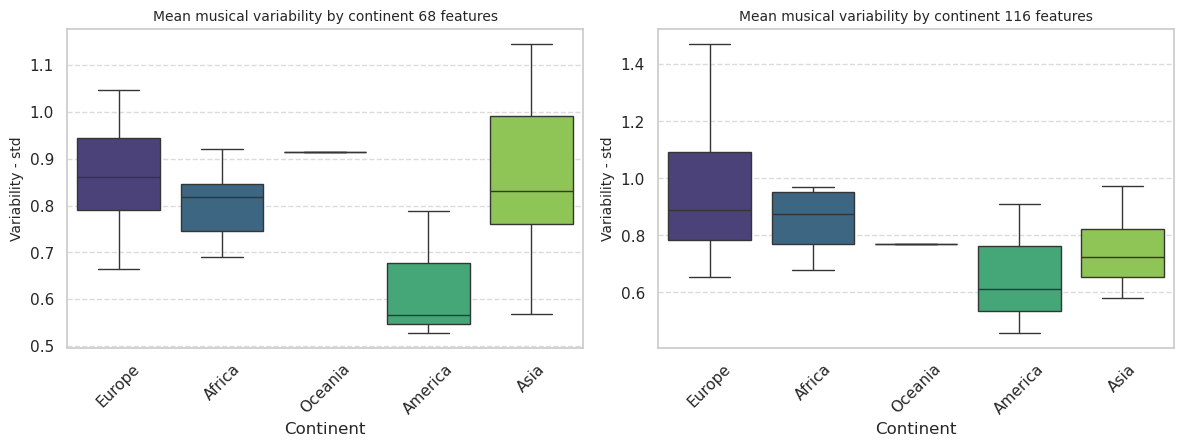

In [92]:
#Boxplot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(
    x='Continent', 
    y='Mean_var', 
    data=df_std_country_68, 
    hue = 'Continent',
    palette='viridis' 
)
plt.title('Mean musical variability by continent 68 features', fontsize=10)
plt.ylabel('Variability - std', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.subplot(2, 2, 2)
sns.boxplot(
    x='Continent', 
    y='Mean_var', 
    data=df_std_country_116, 
    hue = 'Continent',
    palette='viridis' 
)
plt.title('Mean musical variability by continent 116 features', fontsize=10)
plt.ylabel('Variability - std', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

#### Extra boxplot per region

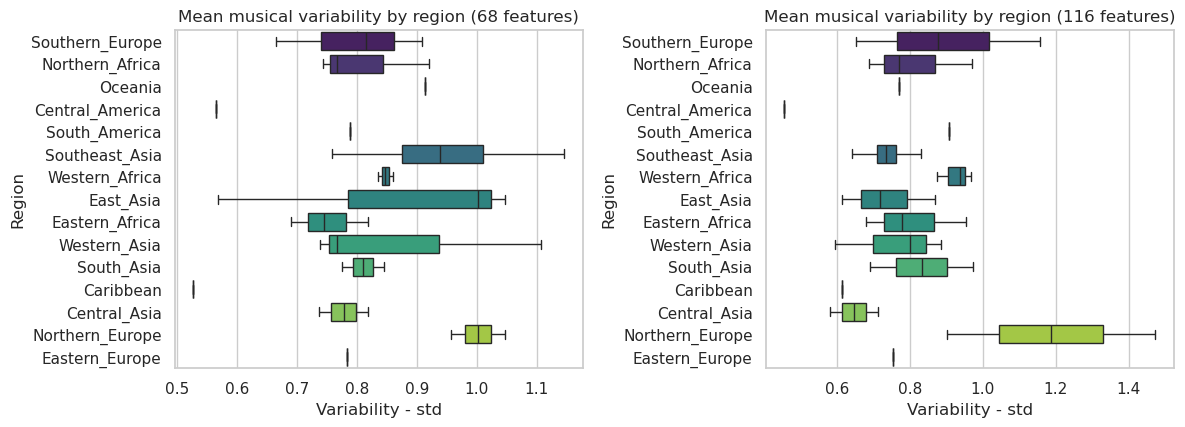

In [210]:
#Boxplot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(
    x='Mean_var',  # Swap x and y
    y='Region', 
    data=df_std_country_68, 
    hue='Region',
    palette='viridis',
    legend=False
)
plt.title('Mean musical variability by region (68 features)')
plt.xlabel('Variability - std')
plt.subplot(2, 2, 2)
sns.boxplot(
    x='Mean_var',  # Swap x and y
    y='Region', 
    data=df_std_country_116, 
    hue='Region',
    palette='viridis',
    legend=False
)
plt.title('Mean musical variability by region (116 features)')
plt.xlabel('Variability - std')
plt.tight_layout()
plt.show()

### Hypothesis 3, dataset structure
<br>H0: The distributions of the mean silhouette coefficients are the same across all continent; therefore, cluster quality is similar across continents.</br>
<br>H1: At least one continent has a distribution of mean silhouette coefficients that differs significantly from the others; therefore, at least one cluster quality differs from others.</br>

In [94]:
#68 features dataset
#Compute distance matrix to see the cohesion within the country
distance_matrix_68 = euclidean_distances(X_68)
labels_country_68 = df_68['Country']
df_distance_68 = pd.DataFrame(distance_matrix_68, index=labels_country_68.index, columns=labels_country_68.index)
#Distance within the country
country_results_68 = []
all_countries_68 = labels_country_68.unique()
for country in all_countries_68:
    indices = labels_country_68[labels_country_68 == country].index
    #Distance within each country
    intra_df_distance_68 = df_distance_68.loc[indices, indices]
    #As it is a diagonal and symetric matrix, it has to be computed the mean of the superior or inferior part of the matrix
    if intra_df_distance_68.shape[0] > 1: #Ignore if a country has only one sample
        mean_intra_distance = np.mean(pdist(X_68.loc[indices, :], metric='euclidean'))
    else:
        mean_intra_distance = np.nan
    country_results_68.append({
        'Country': country,
        'Mean_Intra_Distance': mean_intra_distance
    })

#Silhoutte score for each country
label_encoder_68 = {name: i for i, name in enumerate(all_countries_68)}
labels_encoded_68 = np.array([label_encoder_68[c] for c in labels_country_68])

sample_silhouette_values_68 = silhouette_samples(X_68, labels_encoded_68, metric='euclidean')
df_silhouette_68 = pd.DataFrame({
    'Country': labels_country_68,
    'Silhouette_Coeff': sample_silhouette_values_68})
mean_silhouette_by_country_68 = df_silhouette_68.groupby('Country')['Silhouette_Coeff'].mean()
for item in country_results_68:
    country = item['Country']
    item['Mean_Silhouette_Coeff'] = mean_silhouette_by_country_68.loc[country]


hd3_68_results = pd.DataFrame(country_results_68).sort_values(by='Mean_Silhouette_Coeff', ascending=False)
hd3_68_results

,Country,Mean_Intra_Distance,Mean_Silhouette_Coeff
18,Taiwan,7.447451,0.203712
20,Jamaica,6.527334,0.198098
25,Belize,7.486832,0.183465
31,Cambodia,9.304427,0.076559
15,Myanmar,11.119804,0.034308
26,Greece,7.943352,0.022756
29,Tanzania,8.280591,-0.023475
30,Georgia,9.624554,-0.031925
23,Kyrgyzstan,10.058106,-0.038609
3,Ethiopia,9.000915,-0.053234


In [95]:
#116 features dataset
#Compute distance matrix to see the cohesion within the country
distance_matrix_116 = euclidean_distances(X_116)
labels_country_116 = df_116['Country']
df_distance_116 = pd.DataFrame(distance_matrix_116, index=labels_country_116.index, columns=labels_country_116.index)
#Distance within the country
country_results_116 = []
all_countries_116 = labels_country_116.unique()
for country in all_countries_116:
    indices = labels_country_116[labels_country_116 == country].index
    #Distance within each country
    intra_df_distance_116 = df_distance_116.loc[indices, indices]
    #As it is a diagonal and symetric matrix, it has to be computed the mean of the superior or inferior part of the matrix
    if intra_df_distance_116.shape[0] > 1: #Ignore if a country has only one sample
        mean_intra_distance = np.mean(pdist(X_116.loc[indices, :], metric='euclidean'))
    else:
        mean_intra_distance = np.nan
    country_results_116.append({
        'Country': country,
        'Mean_Intra_Distance': mean_intra_distance
    })

#Silhoutte score for each country
label_encoder_116 = {name: i for i, name in enumerate(all_countries_116)}
labels_encoded_116 = np.array([label_encoder_116[c] for c in labels_country_116])

sample_silhouette_values_116 = silhouette_samples(X_116, labels_encoded_116, metric='euclidean')
df_silhouette_116 = pd.DataFrame({
    'Country': labels_country_116,
    'Silhouette_Coeff': sample_silhouette_values_116})
mean_silhouette_by_country_116 = df_silhouette_116.groupby('Country')['Silhouette_Coeff'].mean()
for item in country_results_116:
    country = item['Country']
    item['Mean_Silhouette_Coeff'] = mean_silhouette_by_country_116.loc[country]


hd3_116_results = pd.DataFrame(country_results_116).sort_values(by='Mean_Silhouette_Coeff', ascending=False)
hd3_116_results

,Country,Mean_Intra_Distance,Mean_Silhouette_Coeff
25,Belize,8.033669,0.222305
20,Jamaica,9.356603,0.198631
18,Taiwan,9.515124,0.113977
31,Cambodia,10.317176,0.086262
15,Myanmar,12.065294,0.044948
30,Georgia,10.221533,0.015272
7,Uzbekistan,9.363897,0.011553
26,Greece,9.588300,-0.013723
23,Kyrgyzstan,11.086011,-0.055754
13,Algeria,10.394701,-0.057806


In [96]:
hd3_68_results['Continent'] = hd3_68_results['Country'].map(lambda x: region_map.get(x)).map(continent_map)
#Group by continent
continents_data_68_h3 = []
for continent in hd3_68_results['Continent'].unique():
    continent_coeff = hd3_68_results[hd3_68_results['Continent'] == continent]['Mean_Silhouette_Coeff'].values #Compute the mean Silhoutte score by continent (the mean of siloutte score of the countries belonging to the same continent)
    continent_coeff = continent_coeff[~np.isnan(continent_coeff)]
    if len(continent_coeff) > 1: #Include just continents with more than 1 country (as before)
        continents_data_68_h3.append(continent_coeff)

#Test Kruskal-Wallis across continents
if len(continents_data_68_h3) >= 2: #More than 2 contienents obtained
    H_stat, p_value_hd3_68 = stats.kruskal(*continents_data_68_h3)
    print(f'Continents: {len(continents_data_68)}\np-value:{p_value_hd3_68}\nH0: {('Rejected' if p_value_hd3_68 < 0.05 else 'Rejection failed')}')

Continents: 4
p-value:0.4211063416261257
H0: Rejection failed


In [97]:
hd3_116_results['Continent'] = hd3_116_results['Country'].map(lambda x: region_map.get(x)).map(continent_map)
#Group by continent
continents_data_116_h3 = []
for continent in hd3_116_results['Continent'].unique():
    continent_coeff = hd3_116_results[hd3_116_results['Continent'] == continent]['Mean_Silhouette_Coeff'].values
    continent_coeff = continent_coeff[~np.isnan(continent_coeff)]
    if len(continent_coeff) > 1: #Include just continents with more than 1 country (as before)
        continents_data_116_h3.append(continent_coeff)

#Test Kruskal-Wallis
if len(continents_data_116_h3) >= 2: #More than 2 contienents obtained
    H_stat, p_value_hd3_116 = stats.kruskal(*continents_data_116_h3)
    print(f'Continents: {len(continents_data_116)}\np-value:{p_value_hd3_116}\nH0: {('Rejected' if p_value_hd3_116 < 0.05 else 'Rejection failed')}')

Continents: 4
p-value:0.17214087345007278
H0: Rejection failed


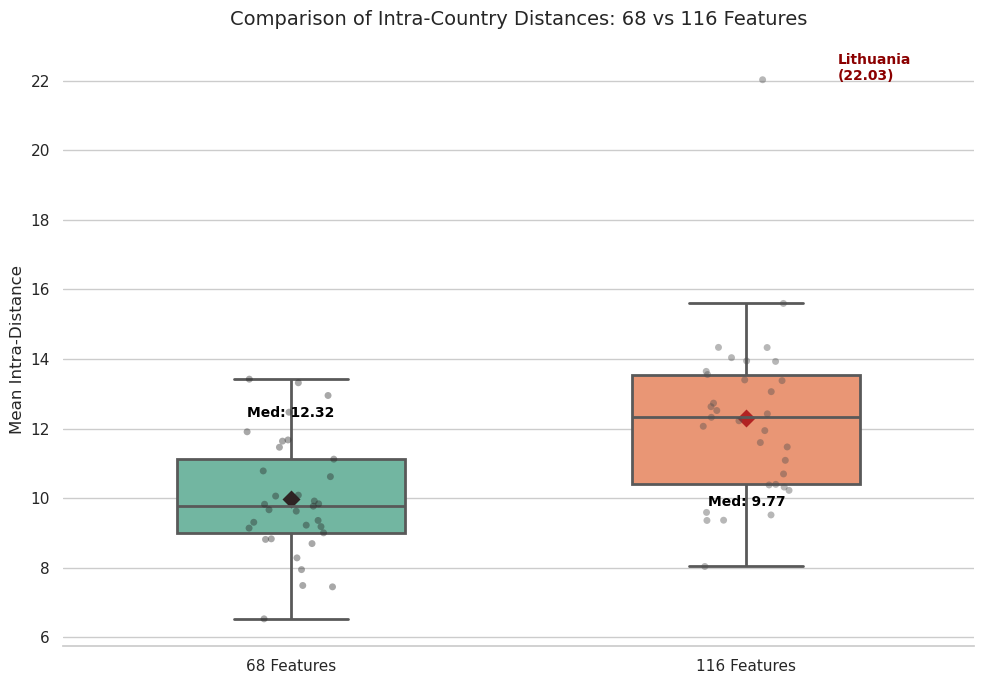

In [211]:
#Long format of dataset
df68 = pd.DataFrame({
    'Distance': hd3_68_results['Mean_Intra_Distance'], 
    'Features': '68 Features',
    'Country': hd3_68_results['Country']
})
df116 = pd.DataFrame({
    'Distance': hd3_116_results['Mean_Intra_Distance'], 
    'Features': '116 Features',
    'Country': hd3_116_results['Country']
})
combined_df = pd.concat([df68, df116]).reset_index(drop=True)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='Features', y='Distance', hue = 'Features', data=combined_df, palette="Set2", width=0.5, fliersize=0, linewidth=2)
sns.stripplot(x='Features', y='Distance', hue = 'Features', data=combined_df, size=5, palette='dark:.3', linewidth=0, alpha=0.4,jitter=True)
#Get the oulier
max_idx = combined_df['Distance'].idxmax()
max_row = combined_df.loc[max_idx]
max_val = max_row['Distance']
max_name = max_row['Country']
x_pos = 0 if max_row['Features'] == '68 Features' else 1
ax.annotate(f'{max_name}\n({max_val:.2f})', xy=(x_pos, max_val), xytext=(x_pos + 0.2, max_val), arrowprops=dict(facecolor='black', arrowstyle='->',connectionstyle='arc3,rad=.2'),fontsize=10, fontweight='bold', color='darkred')
sns.pointplot(x='Features', y='Distance', hue = 'Features',data=combined_df, estimator='mean', errorbar=None,markers='D', palette='dark:firebrick', label='Mean')
plt.title('Comparison of Intra-Country Distances: 68 vs 116 Features', fontsize=14, pad=20)
plt.ylabel('Mean Intra-Distance', fontsize=12)
plt.xlabel('', fontsize=12)
medians = combined_df.groupby(['Features'])['Distance'].median().values
for i, median in enumerate(medians):
    ax.text(i, median + 0.01, f'Med: {median:.2f}', 
            horizontalalignment='center', size='small', color='black', weight='semibold')
sns.despine(left=True)
plt.tight_layout()
plt.show()


The results are consistent with the tsne plot 

#### Inter-distance network graph 

In [213]:
#Get the unique countries.
countries = labels_country_68.unique()
country_distance_matrix = pd.DataFrame(
    np.zeros((len(countries), len(countries))),
    index=countries,
    columns=countries
)
#Create loop to compute distance between each pair of countries
for c1, c2 in combinations(countries, 2):
    idx1 = labels_country_68[labels_country_68 == c1].index
    idx2 = labels_country_68[labels_country_68 == c2].index
    dist = pairwise_distances(
        X_68.loc[idx1],
        X_68.loc[idx2],
        metric="euclidean"
    ).mean()
    country_distance_matrix.loc[c1, c2] = dist
    country_distance_matrix.loc[c2, c1] = dist


In [214]:
#Set a threshold to just keep the main 25% distances
threshold = np.percentile(
    country_distance_matrix.values[country_distance_matrix.values > 0],25)

In [215]:
#Build the graph
G = nx.Graph()
for c in countries:
    G.add_node(c)
for c1, c2 in combinations(countries, 2):
    d = country_distance_matrix.loc[c1, c2]
    if d <= threshold:
        G.add_edge(c1, c2, weight=d)


/tmp/ipykernel_169/1273877353.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20b', len(unique_regions))


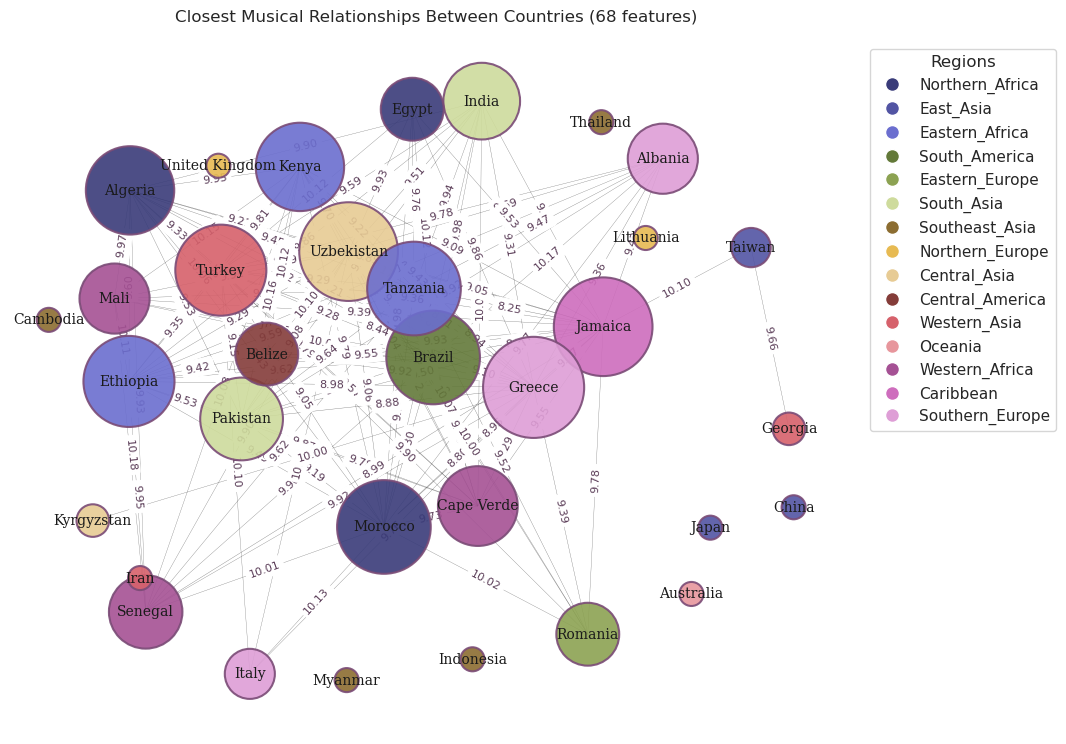

In [216]:
#Establish spring layout to make far the nodes with greater distance
pos = nx.spring_layout(G, seed=2000, k=5, iterations=50)
degrees = dict(G.degree())
node_sizes = [300 + degrees[n]*250 for n in G.nodes()] 
#To set the coulours of the countries by region
unique_regions = list(set(region_map.values()))
palette = plt.cm.get_cmap('tab20b', len(unique_regions))
color_lookup = {region: palette(i) for i, region in enumerate(unique_regions)}
node_colors = [color_lookup[region_map[n]] for n in G.nodes()]

#Plot the network graph
plt.figure(figsize=(11,9))
#Nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, linewidths=1.5, edgecolors="#7a4b76")
#Nodes labels by country
nx.draw_networkx_labels(G, pos, font_size=10,font_family="serif")
#Edges by distance
weights = [1/(1+G[u][v]['weight']) for u,v in G.edges()] 
nx.draw_networkx_edges(G, pos, width=[2.5*w for w in weights], alpha=0.6, style="solid")
#Edges labells with distance
edge_labels = {(u,v): f"{G[u][v]['weight']:.2f}"for u,v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8,font_color="#5a3c57")
plt.title("Closest Musical Relationships Between Countries (68 features)",pad=14)
plt.axis("off")
legend_elements = [Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=10) for region, color in color_lookup.items()]
plt.legend(handles=legend_elements, title="Regions", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


## Models Hypotheses

### Hypothesis 1, feature dimensionality
<br>H0: The mean performance (F1-score) of the model (M) using 116 features is not significantly better (greater) than the mean performance of the same model (M) using 68 features; therefore, using more features does not improve the performance of the model (M).</br>
$\mu_{116}^{M} \leq \mu_{68}^{M}$
<br>H1: The mean performance (F1-score) of the model (M) using 116 features is significantly better (greater) than the mean performance of the same model (M) using 68 features; therefore, using more features improves the performance of the model (M).</br>
$\mu_{116}^{M} > \mu_{68}^{M}$

In [99]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2000)
#As for PCA and SVD 556 components were found to keep 99% of variance, it will be set at this for the transformation
datasets = {
    'X_68': X_68,
    'X_116': X_116}

In [100]:
#Models to evaluate with the hyperparameters obtained previously, as they are different the models will be separated
#As best paramneters for KNN differ for the datasets will be splitted
#For 68 features dataset
models_full_68 = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'RandomForest': RandomForestClassifier(random_state=2000, max_depth = None, max_features = 1.0, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300),
    'KNN': KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5, weights = 'distance'),
    'SVM': SVC(C= 10, gamma= 'scale', kernel = 'rbf',random_state=2000)
}
#For 116 features full dataset
models_full_116 = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'RandomForest': RandomForestClassifier(random_state=2000, max_depth = None, max_features = 1.0, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200),
    'KNN': KNeighborsClassifier(metric = 'euclidean', n_neighbors = 3, weights = 'distance'),
    'SVM': SVC(C= 10, gamma= 'scale', kernel = 'rbf',random_state=2000)
}

In [101]:
results_h1_68 = []
for model_name, model in models_full_68.items():
    scores = cross_validate(model, X_68, y_68, cv=cv, scoring='f1_weighted', return_train_score=False, n_jobs=-1, return_estimator=True)
    f1_scores_list = scores['test_score'].tolist() 
    f1_mean = np.mean(f1_scores_list)
    f1_std = np.std(f1_scores_list)
    fit_time_mean = np.mean(scores['fit_time'])
    score_time_mean = np.mean(scores['score_time']) 
    
    results_h1_68.append({
        'Dataset': 'X_68',
        'Model': model_name,
        'F1_mean': f1_mean, 
        'F1_std': f1_std,
        'F1_Scores_List': f1_scores_list,        
        'Fit_Time_sec': fit_time_mean,
        'Score_Time_sec': score_time_mean
    })

In [102]:
results_h1_116 = []
for model_name, model in models_full_116.items():
    scores = cross_validate(model, X_116, y_116, cv=cv, scoring='f1_weighted', return_train_score=False, n_jobs=-1, return_estimator=True)
    f1_scores_list = scores['test_score'].tolist() 
    f1_mean = np.mean(f1_scores_list)
    f1_std = np.std(f1_scores_list)
    fit_time_mean = np.mean(scores['fit_time'])
    score_time_mean = np.mean(scores['score_time']) 
    
    results_h1_116.append({
        'Dataset': 'X_116',
        'Model': model_name,
        'F1_mean': f1_mean, 
        'F1_std': f1_std,
        'F1_Scores_List': f1_scores_list,        
        'Fit_Time_sec': fit_time_mean,
        'Score_Time_sec': score_time_mean
    })

In [103]:
results_h1 = results_h1_68 + results_h1_116           
df_results_h1 = pd.DataFrame(results_h1).sort_values(by='F1_mean', ascending=False)
df_results_h1

,Dataset,Model,F1_mean,F1_std,F1_Scores_List,Fit_Time_sec,Score_Time_sec
5,X_116,RandomForest,0.451227,0.021196,"[0.46343614602712685, 0.4490520869306867, 0.45...",19.940797,0.023244
3,X_68,SVM,0.448813,0.017129,"[0.4487251761110556, 0.4811186380946144, 0.441...",0.086645,0.017115
1,X_68,RandomForest,0.444384,0.016974,"[0.45994975793635173, 0.4535802180433146, 0.44...",19.065287,0.035498
7,X_116,SVM,0.415142,0.023097,"[0.40591583992527386, 0.3880768392193849, 0.44...",0.098568,0.021559
2,X_68,KNN,0.386892,0.027563,"[0.38528534748491505, 0.43778746297351356, 0.3...",0.002090,0.010832
6,X_116,KNN,0.349130,0.010860,"[0.3342731099310047, 0.35529858911630063, 0.36...",0.003135,0.007491
0,X_68,Dummy,0.007978,0.000447,"[0.008181666388378694, 0.008181666388378694, 0...",0.000941,0.001909
4,X_116,Dummy,0.007978,0.000447,"[0.008181666388378694, 0.008181666388378694, 0...",0.001105,0.001986


In [104]:
p_values_h1 = [] 
p_un_list_h1 = [] 
model_test = df_results_h1['Model'].unique() #To get unique values

for model in model_test:
    #Scores from dataset with 68 features
    row_68 = df_results_h1.loc[(df_results_h1['Model'] == model) & (df_results_h1['Dataset'] == 'X_68')].iloc[0]
    scores_68 = np.array(row_68['F1_Scores_List'])    
    #Scores from dataset with 116 features
    row_116 = df_results_h1.loc[(df_results_h1['Model'] == model) & (df_results_h1['Dataset'] == 'X_116')].iloc[0]
    scores_116 = np.array(row_116['F1_Scores_List'])
    
    #One-tailed t test to see if 116 features dataset has a greater mean (better perfomance) than the 68 features dataset for each model
    t_stat, p_value = stats.ttest_rel(scores_116, scores_68, alternative='greater')
    p_un_list_h1.append(p_value)    
    p_values_h1.append({
        'Model': model,
        'p_value_uncorrected': p_value, 
        'F1_mean_68': row_68['F1_mean'],
        'F1_mean_116': row_116['F1_mean'],
        'Difference': row_116['F1_mean'] - row_68['F1_mean']
    })
#Bonferroni correction
df_p_values_h1 = pd.DataFrame(p_values_h1)
reject_list, p_corr, _, _ = multipletests(
    p_un_list_h1, 
    alpha=0.05, 
    method='bonferroni')

#Add correect p_value
df_p_values_h1['p_value_corrected'] = p_corr
df_p_values_h1['H0_status'] = np.where(df_p_values_h1['p_value_corrected'] < 0.05, 'Rejected', 'Rejection failed')
df_p_values_h1 = df_p_values_h1.sort_values(by='p_value_corrected')

In [105]:
df_p_values_h1

,Model,p_value_uncorrected,F1_mean_68,F1_mean_116,Difference,p_value_corrected,H0_status
0,RandomForest,0.132372,0.444384,0.451227,0.006843,0.529487,Rejection failed
1,SVM,0.928894,0.448813,0.415142,-0.033671,1.000000,Rejection failed
2,KNN,0.975689,0.386892,0.349130,-0.037762,1.000000,Rejection failed
3,Dummy,NaN,0.007978,0.007978,0.000000,NaN,Rejection failed


### Hypothesis 2, dimensionality reduction effect
<br>H0: The mean performance (F1-score) of the model (M) using a reduction technique (RT), PCA, SVD, is not significantly worse than the mean performance of the same model (M) using the full dataset; therefore, the dimensionality reduction does not decrease the performance of model (M).</br>
$\mu_{RT}^{M} \geq \mu_{Full}^{M}$
<br>H1: The mean performance (F1-score) of the model (M) using a reduction technique (RT), PCA, SVD, is significantly worse than the mean performance of the same model (M) using the full dataset; therefore, the dimensionality reduction decreases the performance of model (M).</br>
$\mu_{RT}^{M} < \mu_{Full}^{M}$

In [106]:
#As for PCA and SVD 56 components were found to keep 99% of variance, it will be set at this for the transformation
#PCA
pca = PCA(n_components=56)
X_68_pca_cv = pca.fit_transform(X_68)
X_116_pca_cv = pca.fit_transform(X_116)
#SVD
svd = TruncatedSVD(n_components=56)
X_68_svd_cv = svd.fit_transform(X_68)
X_116_svd_cv = svd.fit_transform(X_116)


In [107]:
#As for PCA and SVD 556 components were found to keep 99% of variance, it will be set at this for the transformation
#PCA
pca = PCA(n_components=56)
X_68_pca_cv = pca.fit_transform(X_68)
X_116_pca_cv = pca.fit_transform(X_116)
#SVD
svd = TruncatedSVD(n_components=56)
X_68_svd_cv = svd.fit_transform(X_68)
X_116_svd_cv = svd.fit_transform(X_116)

datasets_red = {
    'X_68_PCA': X_68_pca_cv,
    'X_116_PCA': X_116_pca_cv,
    'X_68_SVD': X_68_svd_cv,
    'X_116_SVD': X_116_svd_cv}
#Define datasets separated
datasets_red_68 = {
    'X_68_PCA': X_68_pca_cv,
    'X_68_SVD': X_68_svd_cv}
datasets_red_116 = {
    'X_116_PCA': X_116_pca_cv,
    'X_116_SVD': X_116_svd_cv}

In [108]:
#For both reductions, the same hyperparmeters were obtained
models_red_68 = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, class_weight='balanced', random_state=2000, n_jobs=-1),
    'KNN': KNeighborsClassifier(metric = 'euclidean', n_neighbors = 5, weights = 'distance'),
    'SVM': SVC(C= 10, gamma= 'scale', kernel = 'rbf',random_state=2000)}
models_red_116 = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=10,class_weight='balanced',random_state=2000,n_jobs=-1),
    'KNN': KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5, weights = 'distance'),
    'SVM': SVC(C= 10, gamma= 'scale', kernel = 'rbf',random_state=2000)}

In [109]:
results_h2_68 = []
#As the full datasets were already obtained its evaluations, then just the reduced will be here
for dataset_name, data in datasets_red_68.items():
    for model_name, model in models_red_68.items():
        scores = cross_validate(model, data, y_68, cv=cv, scoring='f1_weighted', return_train_score=False, n_jobs=-1, return_estimator=True)
        f1_scores_list = scores['test_score'].tolist() 
        f1_mean = np.mean(f1_scores_list)
        f1_std = np.std(f1_scores_list)
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time']) 
        
        results_h2_68.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'F1_mean': f1_mean, 
            'F1_std': f1_std,
            'F1_Scores_List': f1_scores_list,        
            'Fit_Time_sec': fit_time_mean,
            'Score_Time_sec': score_time_mean
    })

In [110]:
results_h2_116 = []
#As the full datasets were already obtained its evaluations, then just the reduced will be here
for dataset_name, data in datasets_red_116.items():
    for model_name, model in models_red_116.items():
        scores = cross_validate(model, data, y_116, cv=cv, scoring='f1_weighted', return_train_score=False, n_jobs=-1, return_estimator=True)
        f1_scores_list = scores['test_score'].tolist() 
        f1_mean = np.mean(f1_scores_list)
        f1_std = np.std(f1_scores_list)
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time']) 
        
        results_h2_116.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'F1_mean': f1_mean, 
            'F1_std': f1_std,
            'F1_Scores_List': f1_scores_list,        
            'Fit_Time_sec': fit_time_mean,
            'Score_Time_sec': score_time_mean
    })

In [111]:
results_h2_red = results_h2_68 + results_h2_116  
results_h2 = results_h1 + results_h2_red            
df_results_h2 = pd.DataFrame(results_h2).sort_values(by='F1_mean', ascending=False)   
df_results_h2

,Dataset,Model,F1_mean,F1_std,F1_Scores_List,Fit_Time_sec,Score_Time_sec
5,X_116,RandomForest,0.451227,0.021196,"[0.46343614602712685, 0.4490520869306867, 0.45...",19.940797,0.023244
3,X_68,SVM,0.448813,0.017129,"[0.4487251761110556, 0.4811186380946144, 0.441...",0.086645,0.017115
15,X_68_SVD,SVM,0.447886,0.011005,"[0.44364829320930665, 0.4676480393490733, 0.43...",0.099406,0.016798
11,X_68_PCA,SVM,0.447886,0.011005,"[0.44364829320930665, 0.4676480393490733, 0.43...",0.099121,0.016859
1,X_68,RandomForest,0.444384,0.016974,"[0.45994975793635173, 0.4535802180433146, 0.44...",19.065287,0.035498
19,X_116_PCA,SVM,0.417383,0.020065,"[0.4057809519179926, 0.4010142095851911, 0.450...",0.106849,0.016923
7,X_116,SVM,0.415142,0.023097,"[0.40591583992527386, 0.3880768392193849, 0.44...",0.098568,0.021559
23,X_116_SVD,SVM,0.414846,0.017651,"[0.40502496786012177, 0.4010142095851911, 0.44...",0.106935,0.016951
2,X_68,KNN,0.386892,0.027563,"[0.38528534748491505, 0.43778746297351356, 0.3...",0.002090,0.010832
9,X_68_PCA,RandomForest,0.374264,0.013756,"[0.36767453777886516, 0.36352523235022083, 0.3...",0.282498,0.056319


In [112]:
#Turn the list into object to iterate in the next function to perform ttest
def list_obj(x):
    if isinstance(x, str):
        try:
            return eval(x)
        except (ValueError, SyntaxError):
            return x
    return x

In [113]:
df_results_h2['F1_Scores_List'] = df_results_h2['F1_Scores_List'].apply(list_obj)
df_results_h2

,Dataset,Model,F1_mean,F1_std,F1_Scores_List,Fit_Time_sec,Score_Time_sec
5,X_116,RandomForest,0.451227,0.021196,"[0.46343614602712685, 0.4490520869306867, 0.45...",19.940797,0.023244
3,X_68,SVM,0.448813,0.017129,"[0.4487251761110556, 0.4811186380946144, 0.441...",0.086645,0.017115
15,X_68_SVD,SVM,0.447886,0.011005,"[0.44364829320930665, 0.4676480393490733, 0.43...",0.099406,0.016798
11,X_68_PCA,SVM,0.447886,0.011005,"[0.44364829320930665, 0.4676480393490733, 0.43...",0.099121,0.016859
1,X_68,RandomForest,0.444384,0.016974,"[0.45994975793635173, 0.4535802180433146, 0.44...",19.065287,0.035498
19,X_116_PCA,SVM,0.417383,0.020065,"[0.4057809519179926, 0.4010142095851911, 0.450...",0.106849,0.016923
7,X_116,SVM,0.415142,0.023097,"[0.40591583992527386, 0.3880768392193849, 0.44...",0.098568,0.021559
23,X_116_SVD,SVM,0.414846,0.017651,"[0.40502496786012177, 0.4010142095851911, 0.44...",0.106935,0.016951
2,X_68,KNN,0.386892,0.027563,"[0.38528534748491505, 0.43778746297351356, 0.3...",0.002090,0.010832
9,X_68_PCA,RandomForest,0.374264,0.013756,"[0.36767453777886516, 0.36352523235022083, 0.3...",0.282498,0.056319


In [114]:
#Pivot for ttest
#68 features dataset
df_filtered_68 = df_results_h2[df_results_h2['Dataset'].isin(['X_68', 'X_68_PCA', 'X_68_SVD'])].copy()
ttest_data_68 = []
for i, row in df_filtered_68.iterrows():
    reduction = row['Dataset'].replace('X_68', 'Full').replace('_PCA', 'PCA').replace('_SVD', 'SVD')
    for fold_index, score in enumerate(row['F1_Scores_List']):
        ttest_data_68.append({
                'Model': row['Model'],
                'Reduction_techn': reduction, 
                'Fold_ID': fold_index,                      
                'F1_Score': score                          
            })
df_pivot_68 = pd.DataFrame(ttest_data_68)

#116 features dataset
df_filtered_116 = df_results_h2[df_results_h2['Dataset'].isin(['X_116', 'X_116_PCA', 'X_116_SVD'])].copy()
ttest_data_116 = []
for i, row in df_filtered_116.iterrows():
    reduction = row['Dataset'].replace('X_116', 'Full').replace('_PCA', 'PCA').replace('_SVD', 'SVD')
    for fold_index, score in enumerate(row['F1_Scores_List']):
        ttest_data_116.append({
                'Model': row['Model'],
                'Reduction_techn': reduction, 
                'Fold_ID': fold_index,                      
                'F1_Score': score                          
            })
df_pivot_116 = pd.DataFrame(ttest_data_116)

In [115]:
comparison_datasets_h2 = {
    '68_Features': df_pivot_68[df_pivot_68['Model'] != 'Dummy'].copy(),
    '116_Features': df_pivot_116[df_pivot_116['Model'] != 'Dummy'].copy()
}
all_results_h2 = []
for dataset_name, df_pivot in comparison_datasets_h2.items():    
    models_def = df_pivot['Model'].unique()
    
    for model in models_def:        
        df_comb = df_pivot[df_pivot['Model'] == model].copy()                
        #Save the uncorrected p-values
        p_values_un = []
        tests_info = []        
        #Get full scores for the combination 
        df_full = df_comb[df_comb['Reduction_techn'] == 'Full'].sort_values(by='Fold_ID')
        scores_full = df_full['F1_Score'].values                
        #Get reduction technique
        for reduc_tech in ['FullPCA', 'FullSVD']:            
            df_reduc = df_comb[df_comb['Reduction_techn'] == reduc_tech].sort_values(by='Fold_ID')
            scores_reduc = df_reduc['F1_Score'].values
            
            #Do t-test 
            t_stat, p_value = stats.ttest_rel(scores_reduc, scores_full, alternative='less')                       
            p_values_un.append(p_value)
            tests_info.append({
                'Reduction_techn': reduc_tech,
                'Reduction_techn_mean_F1': np.mean(scores_reduc),
                'Full_Mean_F1': np.mean(scores_full)
            })
            
        #Bonferroni correction
        reject_list, p_corrected, _, _ = multipletests(
            p_values_un, 
            alpha=0.05, 
            method='bonferroni')
        
        for i in range(len(tests_info)):
            all_results_h2.append({
                'Dataset_Size': dataset_name,
                'Model': model,
                'Comparison': f'{tests_info[i]["Reduction_techn"]} vs Full',
                'Model_Mean_F1': tests_info[i]['Reduction_techn_mean_F1'],
                'Full_Mean_F1': tests_info[i]['Full_Mean_F1'],
                'p_value_uncorr': p_values_un[i],
                'p_value_corr_bonf': p_corrected[i],            
                'Null hypothesis': ('Rejected' if p_corrected[i] < 0.05 else 'Rejection failed')
            })

df_all_results_h2 = pd.DataFrame(all_results_h2).sort_values(by='p_value_corr_bonf')

In [116]:
df_all_results_h2

,Dataset_Size,Model,Comparison,Model_Mean_F1,Full_Mean_F1,p_value_uncorr,p_value_corr_bonf,Null hypothesis
6,116_Features,RandomForest,FullPCA vs Full,0.362844,0.451227,0.000080,0.000159,Rejected
7,116_Features,RandomForest,FullSVD vs Full,0.363685,0.451227,0.000221,0.000442,Rejected
3,68_Features,RandomForest,FullSVD vs Full,0.361673,0.444384,0.000785,0.001570,Rejected
2,68_Features,RandomForest,FullPCA vs Full,0.374264,0.444384,0.001115,0.002230,Rejected
4,68_Features,KNN,FullPCA vs Full,0.363059,0.386892,0.038182,0.076363,Rejection failed
5,68_Features,KNN,FullSVD vs Full,0.363190,0.386892,0.038591,0.077181,Rejection failed
0,68_Features,SVM,FullPCA vs Full,0.447886,0.448813,0.424145,0.848291,Rejection failed
1,68_Features,SVM,FullSVD vs Full,0.447886,0.448813,0.424145,0.848291,Rejection failed
9,116_Features,SVM,FullSVD vs Full,0.414846,0.415142,0.471940,0.943880,Rejection failed
8,116_Features,SVM,FullPCA vs Full,0.417383,0.415142,0.759305,1.000000,Rejection failed


### Hypothesis 3, model complexity
<br>H0: The mean performance (F1-score) of the complex model (CM), SVM, Random Forest, in the same dataset (D) (Full, PCA, SVD + 116, 68) is not significantly better (greater) than the mean performance of the simple model (KNN).</br>
$\mu_{CM}^{D} \leq \mu_{KNN}^{D}$
<br>H1: The mean performance (F1-score) of the complex model (CM), SVM, Random Forest, in the same dataset (D) (Full, PCA, SVD + 116, 68) is significantly better (greater) than the mean performance of the simple model (KNN).</br>
$\mu_{CM}^{D} > \mu_{KNN}^{D}$

In [117]:
comparison_datasets = {
    '68_Features': df_pivot_68,
    '116_Features': df_pivot_116
}
ensemble_models = ['RandomForest', 'SVM']
all_results_h3 = []

for data_size, df_pivot in comparison_datasets.items():    
    reduction_techniques = df_pivot['Reduction_techn'].unique()
    
    for reduc_tech in reduction_techniques:        
        df_comb = df_pivot[df_pivot['Reduction_techn'] == reduc_tech].copy()        
        #Save the uncorrected p-value
        p_values_un = []
        tests_info = []
        #Get knn scores for the combination 
        df_knn = df_comb[df_comb['Model'] == 'KNN'].sort_values(by='Fold_ID')
        scores_knn = df_knn['F1_Score'].values
        
        #Get ensemble model
        for model_ensem in ensemble_models:            
            df_ensem = df_comb[df_comb['Model'] == model_ensem].sort_values(by='Fold_ID')
            scores_ensem = df_ensem['F1_Score'].values
            
            #t-test
            t_stat, p_value = stats.ttest_rel(scores_ensem, scores_knn, alternative='greater')            
            p_values_un.append(p_value)
            tests_info.append({
                'Model_Ensemble': model_ensem,
                'Model_Mean_F1': np.mean(scores_ensem),
                'KNN_Mean_F1': np.mean(scores_knn)
            })
        #Bonferroni correction    
        reject_list, p_corrected, _, _ = multipletests(
            p_values_un, 
            alpha=0.05, 
            method='bonferroni'
        )
        
        #Save results
        for i in range(len(tests_info)):
            all_results_h3.append({
                'Dataset_Size': data_size,
                'Reduction': reduc_tech,
                'Comparison': f'{tests_info[i]["Model_Ensemble"]} vs KNN',
                'Model_Mean_F1': tests_info[i]['Model_Mean_F1'],
                'KNN_Mean_F1': tests_info[i]['KNN_Mean_F1'],
                'p_value_uncorr': p_values_un[i], #p uncorrected
                'p_value_corr_bonf': p_corrected[i], #p adjusted
                'Null hypothesis': ('Rejected' if p_corrected[i] < 0.05 else 'Rejection failed')
            })

df_all_results_h3 = pd.DataFrame(all_results_h3).sort_values(by='p_value_corr_bonf')

In [118]:
df_all_results_h3

,Dataset_Size,Reduction,Comparison,Model_Mean_F1,KNN_Mean_F1,p_value_uncorr,p_value_corr_bonf,Null hypothesis
3,68_Features,FullSVD,SVM vs KNN,0.447886,0.363190,0.000182,0.000363,Rejected
5,68_Features,FullPCA,SVM vs KNN,0.447886,0.363059,0.000184,0.000369,Rejected
6,116_Features,Full,RandomForest vs KNN,0.451227,0.349130,0.000312,0.000624,Rejected
1,68_Features,Full,SVM vs KNN,0.448813,0.386892,0.000678,0.001357,Rejected
7,116_Features,Full,SVM vs KNN,0.415142,0.349130,0.001157,0.002313,Rejected
0,68_Features,Full,RandomForest vs KNN,0.444384,0.386892,0.003329,0.006658,Rejected
9,116_Features,FullPCA,SVM vs KNN,0.417383,0.372927,0.023458,0.046915,Rejected
11,116_Features,FullSVD,SVM vs KNN,0.414846,0.373436,0.033702,0.067403,Rejection failed
4,68_Features,FullPCA,RandomForest vs KNN,0.374264,0.363059,0.127766,0.255531,Rejection failed
2,68_Features,FullSVD,RandomForest vs KNN,0.361673,0.363190,0.533569,1.000000,Rejection failed


[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.1s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=19, weights=uniform; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=19, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean,